# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model


#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual.reshape(1,self.imsize)-self.img.reshape(1,self.imsize))/(self.imsize*255)

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(self.imsize)-self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [6]:
model.load_weights('CNN_MNIST.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

# Prepare Data

In [0]:
import pickle
file_ = open('subset', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 100, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  -0.24763575713224856 25
50  :  0.4844865862149402 25
75  :  0.49288905851951925 25
100  :  0.49208660846761004 25
125  :  0.49317629533555374 25
150  :  0.4933462132005865 25
175  :  0.4933462132005865 25
200  :  0.4933462132005865 25
225  :  0.4933462132005865 25
250  :  0.4933462132005865 25
275  :  0.4933462132005865 25
300  :  0.4933462132005865 25
325  :  0.4933462132005865 25
350  :  0.4934884357363691 25
375  :  0.4934884357363691 25
400  :  0.493492147000045 25
425  :  0.493492147000045 25
450  :  0.493492147000045 25
475  :  0.49357334431953925 25
500  :  0.49357334431953925 25
525  :  0.49357334431953925 25
550  :  0.49357334431953925 25
575  :  0.49392619656574804 25
600  :  0.49393231954361755 25
625  :  0.49393231954361755 25
650  :  0.49393231954361755 25
675  :  0.4939595640517975 25
700  :  0.4940347705399111 25
725  :  0.4940301148569587 25
750  :  0.4940673723178486 25
775  :  0.4940716789891778 25
800  :  0.4940716789891778 25
825  :  0.49407177548629105 25
Ti

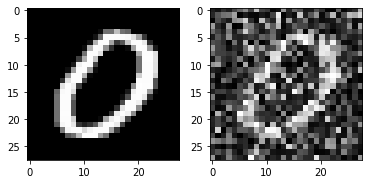

25  :  -0.3608942225654529 25
50  :  0.4909041395097236 25
75  :  0.49250645735474224 25
100  :  0.4924248910012606 25
125  :  0.4929712369879991 25
150  :  0.4929712369879991 25
175  :  0.4929712369879991 25
200  :  0.4930137372552891 25
225  :  0.4930137372552891 25
250  :  0.4930137372552891 25
275  :  0.4930137372552891 25
300  :  0.4930137372552891 25
325  :  0.4930137372552891 25
350  :  0.4931488020112894 25
375  :  0.4931590710966068 25
400  :  0.49320405916263366 25
425  :  0.49320405916263366 25
450  :  0.4934323620951074 25
475  :  0.4934323620951074 25
500  :  0.4934323620951074 25
525  :  0.49343446162038085 25
550  :  0.49343446162038085 25
575  :  0.49343446162038085 25
600  :  0.49343446162038085 25
625  :  0.49343446162038085 25
650  :  0.49343446162038085 25
675  :  0.49343446162038085 25
700  :  0.49363445977702486 25
725  :  0.49363445977702486 25
750  :  0.4936376795810647 25
775  :  0.49365685770197193 25
800  :  0.4936664662799852 25
825  :  0.49369419804421694 2

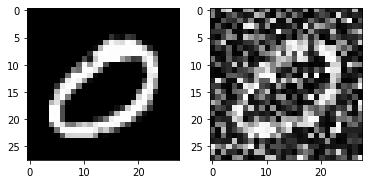

25  :  -0.48553911517416665 25
50  :  -0.4813010353952994 25
75  :  0.45282679787208263 25
100  :  0.4898285022951867 25
125  :  0.49153647009302615 25
150  :  0.4918615250116409 25
175  :  0.4923532310413942 25
200  :  0.4923532310413942 25
225  :  0.4923532310413942 25
250  :  0.4923532310413942 25
275  :  0.49241974795174254 25
300  :  0.49256613278778555 25
325  :  0.49272893548940266 25
350  :  0.49276203820696046 25
375  :  0.4928609952001133 25
400  :  0.4929475226064418 25
425  :  0.4928858711046159 25
450  :  0.4928903093347441 25
475  :  0.49293627285540864 25
500  :  0.4930698325166942 25
525  :  0.49316295937105437 25
550  :  0.49316295937105437 25
575  :  0.49316295937105437 25
600  :  0.4931945058003129 25
625  :  0.4932310882057285 25
650  :  0.49326720046561395 25
675  :  0.493398857401248 25
700  :  0.493398857523386 25
725  :  0.4934292057080127 25
750  :  0.49342920574661364 25
775  :  0.49343494218809936 25
800  :  0.4934621983904196 25
825  :  0.4934623248370913 25

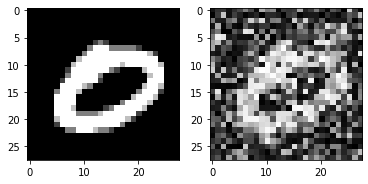

25  :  0.4553530428739858 25
50  :  0.49277096407849413 25
75  :  0.49246679784097913 25
100  :  0.4930938034300984 25
125  :  0.49246679784097913 25
150  :  0.49260754917632976 25
175  :  0.49343914063762084 25
200  :  0.49343914063762084 25
225  :  0.49343914063762084 25
250  :  0.49343914063762084 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


275  :  0.493587927722481 25
300  :  0.49364708046718575 25
325  :  0.49389406553222426 25
350  :  0.49389406553222426 25
375  :  0.49389406553222426 25
400  :  0.49389406553222426 25
425  :  0.49389406553222426 25
450  :  0.493937302834574 25
475  :  0.493937302834574 25
500  :  0.4940380756429473 25
525  :  0.4940380756429473 25
550  :  0.49404829592635346 25
575  :  0.4940831894654909 25
600  :  0.49406825224030965 25
625  :  0.49406825224030965 25
650  :  0.49406825224030965 25
675  :  0.49410665441858675 25
700  :  0.49412884275897123 25
725  :  0.4941542244821891 25
750  :  0.49427249046270716 25
775  :  0.49427249046270716 25
800  :  0.49427249046270716 25
825  :  0.49427249046270716 25
Time:  44.636207580566406  seconds
Predicted class:  [2]


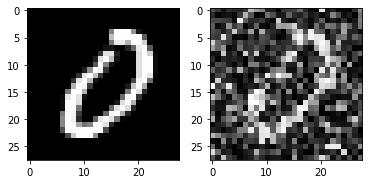

25  :  0.4758673403496569 25
50  :  0.4926653406735763 25
75  :  0.49321266322507457 25
100  :  0.4940618437967358 25
125  :  0.49320797106823705 25
150  :  0.49320797106823705 25
175  :  0.49320797106823705 25
200  :  0.493353019040184 25
225  :  0.4934236585344055 25
250  :  0.49343386752329343 25
275  :  0.49342696088634447 25
300  :  0.49355513525743827 25
325  :  0.4936290822956493 25
350  :  0.4936290822956493 25
375  :  0.4937727427999527 25
400  :  0.49384545514952377 25
425  :  0.49384545514952377 25
450  :  0.49384917112109544 25
475  :  0.49384917112109544 25
500  :  0.49394141611590053 25
525  :  0.4939357360575053 25
550  :  0.49394815271665565 25
575  :  0.4940047532171239 25
600  :  0.4940047532171239 25
625  :  0.4940047532171239 25
650  :  0.4941796610558971 25
675  :  0.4941717780540133 25
700  :  0.49426442669505294 25
725  :  0.49426442669505294 25
750  :  0.49426442669505294 25
775  :  0.49432400457954323 25
800  :  0.4943451844730892 25
825  :  0.4943937158340705 

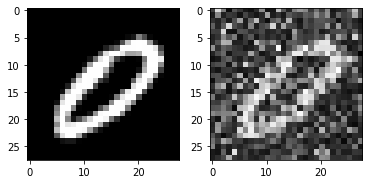

25  :  0.3806347045704676 25
50  :  0.39203419737110845 25
75  :  0.4933006083352827 25
100  :  0.4927690115912227 25
125  :  0.4924256734411661 25
150  :  0.49309673003312054 25
175  :  0.49309673003312054 25
200  :  0.49309673003312054 25
225  :  0.49313202840305526 25
250  :  0.49310203825609283 25
275  :  0.4931765715865068 25
300  :  0.49326757622797435 25
325  :  0.49326757622797435 25
350  :  0.49326757622797435 25
375  :  0.49335613303726844 25
400  :  0.49336369714403105 25
425  :  0.4934590094845878 25
450  :  0.49345569936155587 25
475  :  0.4935594456925265 25
500  :  0.49357674617860686 25
525  :  0.49357674617860686 25
550  :  0.49359241396565406 25
575  :  0.4936191411330126 25
600  :  0.49369987846499014 25
625  :  0.49369450794512443 25
650  :  0.4937330488493239 25
675  :  0.49377788803667416 25
700  :  0.49381776990012616 25
725  :  0.49382621605326504 25
750  :  0.49389693007625624 25
775  :  0.49389693007625624 25
800  :  0.49389693007625624 25
825  :  0.4939143313

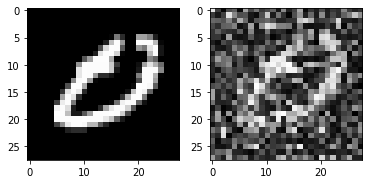

25  :  -0.3491498862528243 25
50  :  0.10647046525406317 25
75  :  0.49265000680291765 25
100  :  0.4916378869658836 25
125  :  0.49135306768682874 25
150  :  0.49243736971453406 25
175  :  0.49257658264293996 25
200  :  0.49254667821483533 25
225  :  0.4926714688141609 25
250  :  0.49269014090926905 25
275  :  0.4927564359338738 25
300  :  0.4929604438676374 25
325  :  0.4931000525486168 25
350  :  0.4931000525486168 25
375  :  0.4931615099992866 25
400  :  0.49318827426984496 25
425  :  0.49316147021756973 25
450  :  0.4932707868288622 25
475  :  0.49332026285529584 25
500  :  0.49336251088807365 25
525  :  0.4933684607613819 25
550  :  0.493417102698715 25
575  :  0.4935704199306473 25
600  :  0.4935704199306473 25
625  :  0.4935704199306473 25
650  :  0.4935704199306473 25
675  :  0.49358686455017126 25
700  :  0.4935870191372109 25
725  :  0.49362461172823435 25
750  :  0.4936620757152246 25
775  :  0.4936636084318406 25
800  :  0.4937165623561317 25
825  :  0.4937176734733071 25


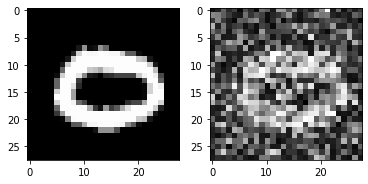

25  :  0.20174380331063463 25
50  :  0.4812974318441889 25
75  :  0.4923555204550823 25
100  :  0.4926090836256006 25
125  :  0.49272065692251876 25
150  :  0.4928967658510771 25
175  :  0.4930504936468512 25
200  :  0.4930504936468512 25
225  :  0.4930504936468512 25
250  :  0.4930504936468512 25
275  :  0.4930615106923112 25
300  :  0.49312865140312434 25
325  :  0.49312884735433427 25
350  :  0.4931939378188296 25
375  :  0.4932066848862006 25
400  :  0.4932066848862006 25
425  :  0.4932066848862006 25
450  :  0.49320935420381484 25
475  :  0.49329097148915885 25
500  :  0.49329920746803874 25
525  :  0.493454960274595 25
550  :  0.49362158956626545 25
575  :  0.49362964703251155 25
600  :  0.49362964703251155 25
625  :  0.49363004415956546 25
650  :  0.4936796510462215 25
675  :  0.49370768147183874 25
700  :  0.49370868021884307 25
725  :  0.49374376173868245 25
750  :  0.4937533248447476 25
775  :  0.49380017632569595 25
800  :  0.4937994305252578 25
825  :  0.49383868496636874 2

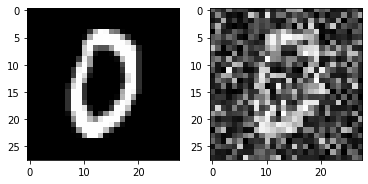

25  :  0.4891519587160625 25
50  :  0.494013790743927 25
75  :  0.49366200393825344 25
100  :  0.4935556976675652 25
125  :  0.4938691766224829 25
150  :  0.4938691766224829 25
175  :  0.4938691766224829 25
200  :  0.4938691766224829 25
225  :  0.4938691766224829 25
250  :  0.4938691766224829 25
275  :  0.4938691766224829 25
300  :  0.4938691766224829 25
325  :  0.49388740050474944 25
350  :  0.49388740050474944 25
375  :  0.49388740050474944 25
400  :  0.49408349915780186 25
425  :  0.4945364587718702 25
450  :  0.4945663876956568 25
475  :  0.4945663876956568 25
500  :  0.4945663876956568 25
525  :  0.4945692821439513 25
550  :  0.49457551370797415 25
575  :  0.4946063339652552 25
600  :  0.49461007638706156 25
625  :  0.49461007638706156 25
650  :  0.49461007638706156 25
675  :  0.49461007638706156 25
700  :  0.49461007638706156 25
725  :  0.4946935929864307 25
750  :  0.4946935929864307 25
775  :  0.4946935929864307 25
800  :  0.4946935929864307 25
Time:  41.51405739784241  seconds

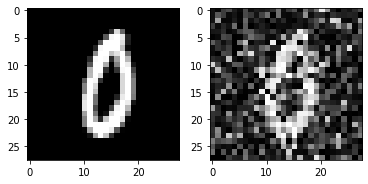

25  :  0.09381697735356472 25
50  :  0.4925074968599636 25
75  :  0.4923350848081192 25
100  :  0.4927476491523679 25
125  :  0.4928013722157144 25
150  :  0.4928013722157144 25
175  :  0.4928013722157144 25
200  :  0.4928013722157144 25
225  :  0.4928013722157144 25
250  :  0.4928013722157144 25
275  :  0.4928013722157144 25
300  :  0.4928013722157144 25
325  :  0.4928013722157144 25
350  :  0.4928013722157144 25
375  :  0.4928766472438622 25
400  :  0.4928962942891738 25
425  :  0.4928962942891738 25
450  :  0.4928962942891738 25
475  :  0.492934491935935 25
500  :  0.4931254651775692 25
525  :  0.49319174005518956 25
550  :  0.4931987636848113 25
575  :  0.4931589972010182 25
600  :  0.4932638561275365 25
625  :  0.49329905303620725 25
650  :  0.4933650256751698 25
675  :  0.4934235003368718 25
700  :  0.49338272618090595 25
725  :  0.49338272618090595 25
750  :  0.49344447959899995 25
775  :  0.4934435021614735 25
800  :  0.49347530333155637 25
825  :  0.4935005579871889 25
Time:  

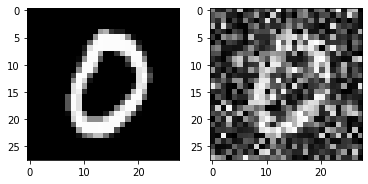

25  :  0.4949051421338636 25
50  :  0.4949051421338636 25
75  :  0.49491184630099433 25
100  :  0.49491184630099433 25
125  :  0.49491184630099433 25
150  :  0.49491184630099433 25
175  :  0.49491184630099433 25
200  :  0.49491184630099433 25
225  :  0.49491184630099433 25
250  :  0.49491184630099433 25
275  :  0.49491184630099433 25
300  :  0.49491184630099433 25
325  :  0.49500311834678146 25
350  :  0.49513454780603405 25
375  :  0.49514184776300013 25
400  :  0.4951420467558157 25
425  :  0.49518325346277414 25
450  :  0.4952172150348586 25
475  :  0.4952172150348586 25
500  :  0.49523016816816756 25
525  :  0.4952583994155627 25
550  :  0.49533025936070085 25
575  :  0.49537686882809506 25
600  :  0.4953822612128331 25
625  :  0.4953822612128331 25
650  :  0.4953822612128331 25
675  :  0.49541573825394963 25
700  :  0.49541573825394963 25
725  :  0.49541573825394963 25
750  :  0.49544382882882154 25
775  :  0.4954570465092366 25
800  :  0.4954627203222781 25
Time:  45.837178468704

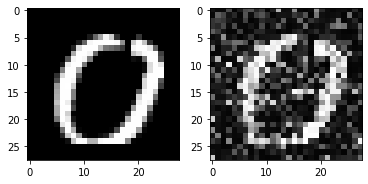

25  :  0.4020183245607674 25
50  :  0.40666480921609127 25
75  :  0.4929895769876227 25
100  :  0.4932858190815676 25
125  :  0.4932858190815676 25
150  :  0.4934756347044588 25
175  :  0.4932858190815676 25
200  :  0.4938084845114162 25
225  :  0.4938268091746433 25
250  :  0.4938268091746433 25
275  :  0.49384508240977837 25
300  :  0.4938703540896709 25
325  :  0.49384508240977837 25
350  :  0.49384508240977837 25
375  :  0.49384508240977837 25
400  :  0.49384508240977837 25
425  :  0.4940135448756474 25
450  :  0.49401602612235235 25
475  :  0.49407870865457154 25
500  :  0.4940860279252497 25
525  :  0.4940960120224699 25
550  :  0.49414415930127437 25
575  :  0.4941578637532528 25
600  :  0.49424426437183694 25
625  :  0.4942408298910592 25
650  :  0.4942613792949904 25
675  :  0.49429497966086544 25
700  :  0.4943144360092763 25
725  :  0.49433020214012624 25
750  :  0.4943328801695264 25
775  :  0.4943412448187933 25
800  :  0.4943414365293846 25
825  :  0.49434937784479643 25


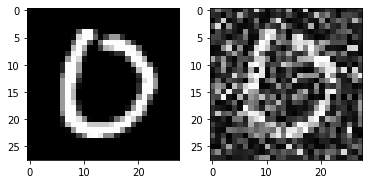

25  :  0.495261946468756 25
50  :  0.495261946468756 25
75  :  0.4954081269322702 25
100  :  0.49540922374395663 25
125  :  0.49540922374395663 25
150  :  0.49540922374395663 25
175  :  0.4955566295302617 25
200  :  0.4956322157969927 25
225  :  0.4956300596140798 25
250  :  0.4956300596140798 25
275  :  0.49582620529170923 25
300  :  0.4958449869991409 25
325  :  0.4958237149462647 25
350  :  0.4958593635836501 25
375  :  0.49595260087030435 25
400  :  0.49594336246144843 25
425  :  0.49594336246144843 25
450  :  0.49595370017393986 25
475  :  0.49595370017393986 25
500  :  0.49601543132342385 25
525  :  0.4960591429991609 25
550  :  0.4961562089874083 25
575  :  0.4961563027748227 25
600  :  0.4961563027748227 25
625  :  0.4962049956289313 25
650  :  0.4962030454550057 25
675  :  0.4962030454550057 25
700  :  0.49623073904364995 25
725  :  0.49623853563745374 25
750  :  0.49623853563745374 25
775  :  0.4962675272357751 25
800  :  0.4962754572937075 25
Time:  46.08273887634277  second

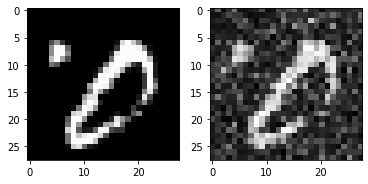

25  :  0.495099092518058 25
50  :  0.495099092518058 25
75  :  0.495099092518058 25
100  :  0.49546448895582207 25
125  :  0.49552571388714645 25
150  :  0.49552571388714645 25
175  :  0.49552571388714645 25
200  :  0.49552571388714645 25
225  :  0.49552571388714645 25
250  :  0.49552571388714645 25
275  :  0.49552571388714645 25
300  :  0.49552571388714645 25
325  :  0.495563175706057 25
350  :  0.495563175706057 25
375  :  0.495563175706057 25
400  :  0.495563175706057 25
425  :  0.495563175706057 25
450  :  0.49559582508168953 25
475  :  0.49559582508168953 25
500  :  0.4956274952810869 25
525  :  0.4956274952810869 25
550  :  0.4956695702033429 25
575  :  0.4956695107057834 25
600  :  0.4956695107057834 25
625  :  0.4957063088614137 25
650  :  0.49571226008356606 25
675  :  0.4957117647450972 25
700  :  0.49572055138767035 25
725  :  0.49573628821270366 25
750  :  0.4957422814460242 25
775  :  0.4957422814460242 25
800  :  0.49574320906896924 25
Time:  47.913666009902954  seconds
P

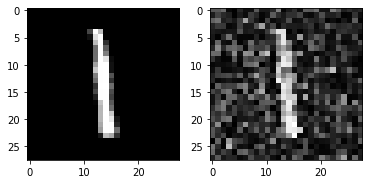

25  :  0.4947313673926961 25
50  :  0.4947313673926961 25
75  :  0.495134299346104 25
100  :  0.4949198402314982 25
125  :  0.4949198402314982 25
150  :  0.4949198402314982 25
175  :  0.4949198402314982 25
200  :  0.4949198402314982 25
225  :  0.4949198402314982 25
250  :  0.4949198402314982 25
275  :  0.4949198402314982 25
300  :  0.4949198402314982 25
325  :  0.4949198402314982 25
350  :  0.4950480281445557 25
375  :  0.49507073405324825 25
400  :  0.49507073405324825 25
425  :  0.49507073405324825 25
450  :  0.49507073405324825 25
475  :  0.4952123494484387 25
500  :  0.49521263663168646 25
525  :  0.49521263663168646 25
550  :  0.49521263663168646 25
575  :  0.49521263663168646 25
600  :  0.4952828136099192 25
625  :  0.49528651398084683 25
650  :  0.49528651398084683 25
675  :  0.49528651398084683 25
700  :  0.49528651398084683 25
725  :  0.4953100581642563 25
750  :  0.49530929321723605 25
775  :  0.49530929321723605 25
800  :  0.49530929321723605 25
Time:  46.64532446861267  sec

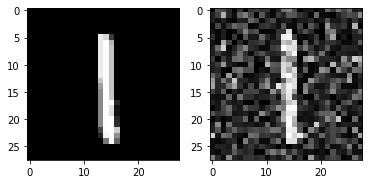

25  :  0.4939711308673153 25
50  :  0.4943573886533986 25
75  :  0.49405308699860184 25
100  :  0.49409028116855297 25
125  :  0.49430385771716473 25
150  :  0.49421264162062334 25
175  :  0.4946312500707631 25
200  :  0.4943332336302071 25
225  :  0.4944515872209599 25
250  :  0.4944515872209599 25
275  :  0.4944515872209599 25
300  :  0.4944944027117834 25
325  :  0.4946129568826915 25
350  :  0.4944917661927269 25
375  :  0.4945012663324697 25
400  :  0.49452684065510294 25
425  :  0.49452684065510294 25
450  :  0.49452684065510294 25
475  :  0.49459096963514715 25
500  :  0.4945872751716029 25
525  :  0.4948057458698678 25
550  :  0.4948120734429771 25
575  :  0.4948120734429771 25
600  :  0.4948120734429771 25
625  :  0.49487252834399886 25
650  :  0.49485049517536833 25
675  :  0.49485049517536833 25
700  :  0.49485049517536833 25
725  :  0.49485049517536833 25
750  :  0.4948811469671022 25
775  :  0.49488386215189145 25
800  :  0.49493574489160264 25
Time:  47.85008692741394  se

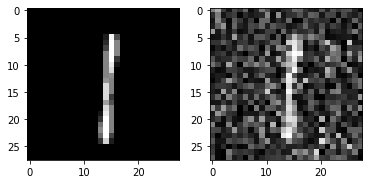

25  :  0.4944036320068228 25
50  :  0.4945373143103448 25
75  :  0.4944036320068228 25
100  :  0.4944036320068228 25
125  :  0.4944036320068228 25
150  :  0.49447209132592446 25
175  :  0.49497022065929697 25
200  :  0.49484504238417687 25
225  :  0.49484504238417687 25
250  :  0.49484504238417687 25
275  :  0.49484504238417687 25
300  :  0.49484504238417687 25
325  :  0.4948878318827834 25
350  :  0.495190109507038 25
375  :  0.49528734183486356 25
400  :  0.4953002059481651 25
425  :  0.4953002059481651 25
450  :  0.4953002059481651 25
475  :  0.4953002059481651 25
500  :  0.4953002059481651 25
525  :  0.4953002059481651 25
550  :  0.4953002059481651 25
575  :  0.4953002059481651 25
600  :  0.4953295089244964 25
625  :  0.4953617554045447 25
650  :  0.49537021596688013 25
675  :  0.49537521341570867 25
700  :  0.4953966129461123 25
725  :  0.4954836976120312 25
750  :  0.4954836976120312 25
775  :  0.4954836976120312 25
800  :  0.4954890776612486 25
Time:  42.732511043548584  seconds

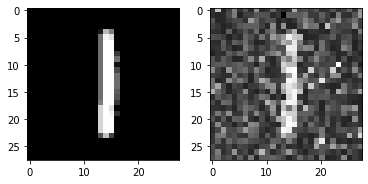

25  :  0.4950277747052118 25
50  :  0.4950277747052118 25
75  :  0.4954421481737429 25
100  :  0.4954421481737429 25
125  :  0.4954421481737429 25
150  :  0.4954421481737429 25
175  :  0.4954421481737429 25
200  :  0.4954421481737429 25
225  :  0.4954497639728032 25
250  :  0.4954497639728032 25
275  :  0.4954497639728032 25
300  :  0.4954497639728032 25
325  :  0.4954497639728032 25
350  :  0.4954497639728032 25
375  :  0.4954497639728032 25
400  :  0.4954497639728032 25
425  :  0.4954497639728032 25
450  :  0.4955024183144529 25
475  :  0.49546030669611774 25
500  :  0.49546030669611774 25
525  :  0.49549568349534784 25
550  :  0.49549568349534784 25
575  :  0.49556124548399066 25
600  :  0.49558188211016757 25
625  :  0.49557996164977836 25
650  :  0.4956103360822991 25
675  :  0.49568435417698453 25
700  :  0.49571207360573444 25
725  :  0.49571234681638765 25
750  :  0.49573339295559815 25
775  :  0.4957347335374204 25
800  :  0.4957419528866802 25
Time:  42.420249938964844  secon

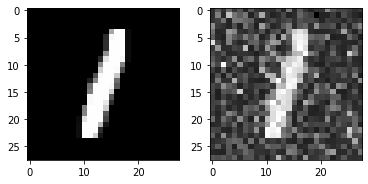

25  :  0.49492908628276816 25
50  :  0.49492908628276816 25
75  :  0.4949054427036254 25
100  :  0.4950482418296169 25
125  :  0.4950482418296169 25
150  :  0.49526453775225077 25
175  :  0.4952606568397928 25
200  :  0.4952606568397928 25
225  :  0.4956199872491111 25
250  :  0.49556323371328487 25
275  :  0.49556323371328487 25
300  :  0.49556323371328487 25
325  :  0.49556323371328487 25
350  :  0.49556323371328487 25
375  :  0.4956539069907973 25
400  :  0.49563225825318746 25
425  :  0.49574499870343675 25
450  :  0.49574499870343675 25
475  :  0.49581276016565345 25
500  :  0.49585320818449413 25
525  :  0.49590056711239766 25
550  :  0.4959349437420332 25
575  :  0.4959349437420332 25
600  :  0.4960421067895333 25
625  :  0.4960421067895333 25
650  :  0.4960421067895333 25
675  :  0.4960421067895333 25
700  :  0.4961034916937567 25
725  :  0.4961034916937567 25
750  :  0.4961034916937567 25
775  :  0.4961034916937567 25
800  :  0.49611094932837146 25
Time:  43.94022059440613  se

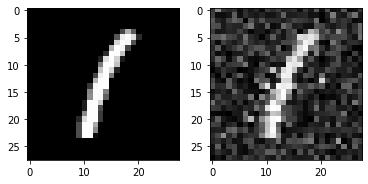

25  :  0.49475712830273527 25
50  :  0.49475712830273527 25
75  :  0.49475712830273527 25
100  :  0.49475712830273527 25
125  :  0.49475712830273527 25
150  :  0.4950128847091451 25
175  :  0.4950128847091451 25
200  :  0.49501471053674817 25
225  :  0.4950197099064961 25
250  :  0.4951632792051137 25
275  :  0.49513427716970526 25
300  :  0.49521396399105916 25
325  :  0.49521396399105916 25
350  :  0.49521396399105916 25
375  :  0.49521396399105916 25
400  :  0.49521396399105916 25
425  :  0.4953065421091117 25
450  :  0.4955602678341441 25
475  :  0.4956322783172666 25
500  :  0.49586908432569443 25
525  :  0.4956723703665699 25
550  :  0.4957593468912609 25
575  :  0.4957901097386789 25
600  :  0.4957901097386789 25
625  :  0.49582949406086213 25
650  :  0.49582949406086213 25
675  :  0.49582949406086213 25
700  :  0.49582949406086213 25
725  :  0.49584385621080407 25
750  :  0.49584385621080407 25
775  :  0.49585862955386784 25
800  :  0.49585862955386784 25
Time:  42.830034494400

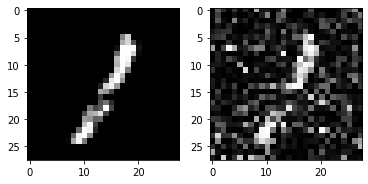

25  :  0.49485366786954443 25
50  :  0.49485366786954443 25
75  :  0.49485366786954443 25
100  :  0.49485366786954443 25
125  :  0.49485366786954443 25
150  :  0.49485366786954443 25
175  :  0.49486909768190285 25
200  :  0.49486909768190285 25
225  :  0.49486909768190285 25
250  :  0.494885243124995 25
275  :  0.4948917514628604 25
300  :  0.49490966683928583 25
325  :  0.4949099500255362 25
350  :  0.49498085878385495 25
375  :  0.49498085878385495 25
400  :  0.49498085878385495 25
425  :  0.49498085878385495 25
450  :  0.49498085878385495 25
475  :  0.49498085878385495 25
500  :  0.49498085878385495 25
525  :  0.49501520847653824 25
550  :  0.49501520847653824 25
575  :  0.49510440252707283 25
600  :  0.4951101638404988 25
625  :  0.495221132121513 25
650  :  0.4952555877842704 25
675  :  0.49525601063216 25
700  :  0.4952509069153208 25
725  :  0.4952842596031067 25
750  :  0.49528402875784205 25
775  :  0.4952916866173634 25
800  :  0.49532251339138345 25
Time:  42.79075527191162 

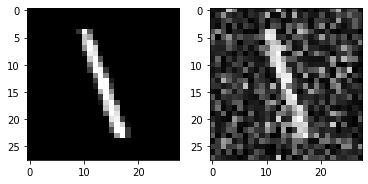

25  :  0.4950064487621922 25
50  :  0.4950064487621922 25
75  :  0.49494764640585065 25
100  :  0.49502873547416093 25
125  :  0.495240438771914 25
150  :  0.4952436282279155 25
175  :  0.4952436282279155 25
200  :  0.4952436282279155 25
225  :  0.4952436282279155 25
250  :  0.4952436282279155 25
275  :  0.4952436282279155 25
300  :  0.4952436282279155 25
325  :  0.4952436282279155 25
350  :  0.4952471617586023 25
375  :  0.4952618682261034 25
400  :  0.49545786274554315 25
425  :  0.49545786274554315 25
450  :  0.49545786274554315 25
475  :  0.49545786274554315 25
500  :  0.49545786274554315 25
525  :  0.49545786274554315 25
550  :  0.49552001553400443 25
575  :  0.49552001553400443 25
600  :  0.4955567971246152 25
625  :  0.4955567971246152 25
650  :  0.4955567971246152 25
675  :  0.4956032711610516 25
700  :  0.4956599798102057 25
725  :  0.4956599798102057 25
750  :  0.4957066144569644 25
775  :  0.49570693796563825 25
800  :  0.49570693796563825 25
Time:  42.369450092315674  secon

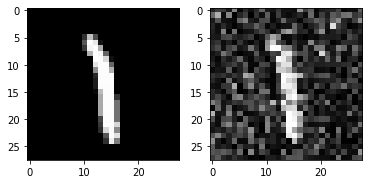

25  :  0.49439091944757685 25
50  :  0.49439091944757685 25
75  :  0.4944844974977994 25
100  :  0.4944844974977994 25
125  :  0.49473835220162876 25
150  :  0.4946776576717323 25
175  :  0.49478079908840134 25
200  :  0.49478079908840134 25
225  :  0.49478079908840134 25
250  :  0.4949894363673583 25
275  :  0.4949809145933702 25
300  :  0.49524214447787385 25
325  :  0.4953038768925506 25
350  :  0.4953038768925506 25
375  :  0.4953038768925506 25
400  :  0.4953767648845188 25
425  :  0.4953628337255587 25
450  :  0.4953628337255587 25
475  :  0.4953628337255587 25
500  :  0.4953628337255587 25
525  :  0.4953658395907808 25
550  :  0.4953658395907808 25
575  :  0.4953658395907808 25
600  :  0.4953658395907808 25
625  :  0.4953658395907808 25
650  :  0.4953658395907808 25
675  :  0.4953658395907808 25
700  :  0.4953885474718306 25
725  :  0.49538875151791645 25
750  :  0.495433787717926 25
775  :  0.4954862243814308 25
800  :  0.49551190493438935 25
Time:  45.22274327278137  seconds
P

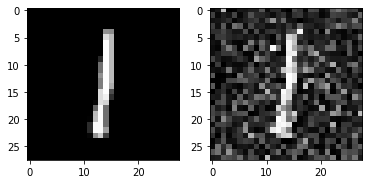

25  :  0.4944792565174551 25
50  :  0.4949457141812758 25
75  :  0.49504572673693076 25
100  :  0.49504572673693076 25
125  :  0.49504572673693076 25
150  :  0.49504572673693076 25
175  :  0.49504572673693076 25
200  :  0.49504572673693076 25
225  :  0.49504572673693076 25
250  :  0.49504572673693076 25
275  :  0.49504572673693076 25
300  :  0.49513243726872436 25
325  :  0.4953040465000112 25
350  :  0.4953040465000112 25
375  :  0.4953040465000112 25
400  :  0.4953040465000112 25
425  :  0.4953040465000112 25
450  :  0.4953040465000112 25
475  :  0.4953040465000112 25
500  :  0.4953040465000112 25
525  :  0.4953121286353817 25
550  :  0.4952634034726999 25
575  :  0.4952755416639709 25
600  :  0.4953131522565295 25
625  :  0.4953131522565295 25
650  :  0.4954945537843404 25
675  :  0.4954948210577103 25
700  :  0.4954948210577103 25
725  :  0.4955038438078316 25
750  :  0.4955849835794423 25
775  :  0.49557539809805934 25
800  :  0.49557539809805934 25
Time:  44.54771876335144  secon

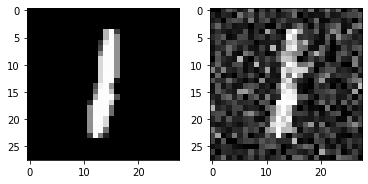

25  :  0.49470162595599776 25
50  :  0.49470162595599776 25
75  :  0.49470162595599776 25
100  :  0.49470162595599776 25
125  :  0.49470162595599776 25
150  :  0.49470162595599776 25
175  :  0.49470162595599776 25
200  :  0.49470162595599776 25
225  :  0.49470162595599776 25
250  :  0.49470162595599776 25
275  :  0.49470162595599776 25
300  :  0.49470162595599776 25
325  :  0.49479983219030316 25
350  :  0.494842427615853 25
375  :  0.494842427615853 25
400  :  0.494842427615853 25
425  :  0.494842427615853 25
450  :  0.494842427615853 25
475  :  0.494842427615853 25
500  :  0.4950846819101441 25
525  :  0.49501193387179593 25
550  :  0.49501193387179593 25
575  :  0.49501193387179593 25
600  :  0.49501193387179593 25
625  :  0.49501193387179593 25
650  :  0.4950119523277671 25
675  :  0.4950119523277671 25
700  :  0.4950119523277671 25
725  :  0.4950123925130368 25
750  :  0.4952003396136641 25
775  :  0.4953077559879227 25
800  :  0.4953077559879227 25
Time:  44.569645404815674  seco

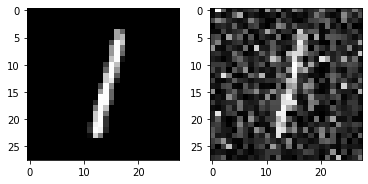

25  :  0.494844452473458 25
50  :  0.494844452473458 25
75  :  0.49464693507925145 25
100  :  0.4948214218660019 25
125  :  0.49479818937490744 25
150  :  0.49479818937490744 25
175  :  0.49479818937490744 25
200  :  0.49479818937490744 25
225  :  0.49479818937490744 25
250  :  0.49504084164106743 25
275  :  0.4950715043792814 25
300  :  0.4950715043792814 25
325  :  0.4951463568574493 25
350  :  0.49518549801097705 25
375  :  0.49518549801097705 25
400  :  0.49518549801097705 25
425  :  0.49519629565871326 25
450  :  0.4951975036045657 25
475  :  0.4951975036045657 25
500  :  0.49524539630228565 25
525  :  0.49524539630228565 25
550  :  0.49524539630228565 25
575  :  0.49524539630228565 25
600  :  0.49524539630228565 25
625  :  0.49524539630228565 25
650  :  0.49527848278823805 25
675  :  0.49529663261059875 25
700  :  0.4953098738245774 25
725  :  0.49531043649325235 25
750  :  0.4953283143185271 25
775  :  0.49536598338471216 25
800  :  0.49536572327681144 25
Time:  44.9675946235656

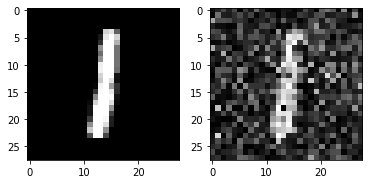

25  :  0.494998696360857 25
50  :  0.49510377313729537 25
75  :  0.494998696360857 25
100  :  0.494998696360857 25
125  :  0.494998696360857 25
150  :  0.49520112753240914 25
175  :  0.49516578846809495 25
200  :  0.49516578846809495 25
225  :  0.49516578846809495 25
250  :  0.49516578846809495 25
275  :  0.49527614825452554 25
300  :  0.4952895451184651 25
325  :  0.4952895451184651 25
350  :  0.49540195710589324 25
375  :  0.49540195710589324 25
400  :  0.49540195710589324 25
425  :  0.49540195710589324 25
450  :  0.49542489855193617 25
475  :  0.49553666502433463 25
500  :  0.49553666502433463 25
525  :  0.49566638824909093 25
550  :  0.4956651322783263 25
575  :  0.4956651322783263 25
600  :  0.4957109778378929 25
625  :  0.4957597511932452 25
650  :  0.49576323532882327 25
675  :  0.49579930782497644 25
700  :  0.49583476175094165 25
725  :  0.4958704764909031 25
750  :  0.49587011707352147 25
775  :  0.49587011707352147 25
800  :  0.49587011707352147 25
Time:  43.957221031188965 

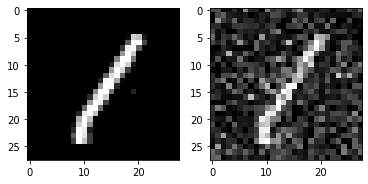

25  :  0.49515436522115197 25
50  :  0.49515436522115197 25
75  :  0.49515436522115197 25
100  :  0.49515436522115197 25
125  :  0.49515436522115197 25
150  :  0.49515436522115197 25
175  :  0.49515436522115197 25
200  :  0.49515436522115197 25
225  :  0.49515436522115197 25
250  :  0.49515436522115197 25
275  :  0.49515436522115197 25
300  :  0.49515436522115197 25
325  :  0.49515436522115197 25
350  :  0.49515436522115197 25
375  :  0.49515436522115197 25
400  :  0.49515436522115197 25
425  :  0.4951849680225693 25
450  :  0.4952040759902427 25
475  :  0.4952295086787502 25
500  :  0.495376859549472 25
525  :  0.495376859549472 25
550  :  0.495376859549472 25
575  :  0.495376859549472 25
600  :  0.495376859549472 25
625  :  0.495376859549472 25
650  :  0.495525243147692 25
675  :  0.495525243147692 25
700  :  0.4955540212517511 25
725  :  0.49558964450950194 25
750  :  0.4955909950185927 25
775  :  0.4956543091178127 25
800  :  0.4956543091178127 25
Time:  42.89777660369873  seconds


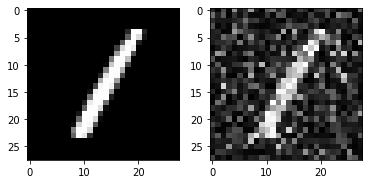

25  :  -0.4980928827017599 25
50  :  -0.48581168564241034 25
75  :  -0.4256698887441778 25
100  :  -0.36787289098508513 25
125  :  0.1335333415668778 25
150  :  0.23548887731650897 25
175  :  0.48839451321634 25
200  :  0.4928363242698371 25
225  :  0.493049636777411 25
250  :  0.4929573265002994 25
275  :  0.49313860614593785 25
300  :  0.49313860614593785 25
325  :  0.4931570518863791 25
350  :  0.49347055423776415 25
375  :  0.49352220017831355 25
400  :  0.49378167407579593 25
425  :  0.49379483622305126 25
450  :  0.49379483622305126 25
475  :  0.49379483622305126 25
500  :  0.49379483622305126 25
525  :  0.49379483622305126 25
550  :  0.4938367103292123 25
575  :  0.4939975158400564 25
600  :  0.4939975158400564 25
625  :  0.4939975158400564 25
650  :  0.4939975158400564 25
675  :  0.49399913887773456 25
700  :  0.49399913887773456 25
725  :  0.49399913887773456 25
750  :  0.4940645891569812 25
775  :  0.49407008237759187 25
800  :  0.4940971560083205 25
825  :  0.494147543911590

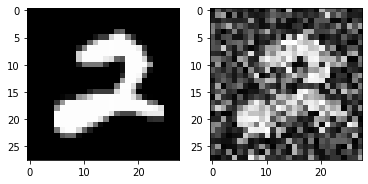

25  :  -0.4624310347995378 25
50  :  0.23402332369604922 25
75  :  0.49281515528633485 25
100  :  0.4924390048246056 25
125  :  0.49225418877993865 25
150  :  0.4928660019380368 25
175  :  0.4928660019380368 25
200  :  0.4928882707408017 25
225  :  0.4928867642596848 25
250  :  0.4928867642596848 25
275  :  0.49291853558757387 25
300  :  0.49316385839271604 25
325  :  0.49316385839271604 25
350  :  0.49316385839271604 25
375  :  0.49320640884765443 25
400  :  0.4932301657687228 25
425  :  0.49329300659003605 25
450  :  0.49331764105764403 25
475  :  0.49331764105764403 25
500  :  0.49339001575147834 25
525  :  0.4935370206102732 25
550  :  0.4935495184648982 25
575  :  0.49355905199017386 25
600  :  0.4935584104660085 25
625  :  0.4935584104660085 25
650  :  0.493604523009514 25
675  :  0.4936477233784809 25
700  :  0.49370860295386193 25
725  :  0.49371410567604185 25
750  :  0.49380483381030943 25
775  :  0.49380550389460254 25
800  :  0.49386567449305335 25
825  :  0.493873706576046

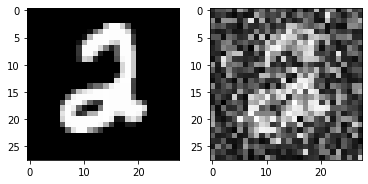

25  :  -0.44604336611724565 25
50  :  0.24047415486503887 25
75  :  0.4580060321273557 25
100  :  0.4914846685262403 25
125  :  0.49137003739204377 25
150  :  0.49175619250797564 25
175  :  0.49190476048816373 25
200  :  0.49212975111312146 25
225  :  0.4922563466454162 25
250  :  0.4923159392683795 25
275  :  0.4924631389103054 25
300  :  0.4924631389103054 25
325  :  0.4924631389103054 25
350  :  0.4928610091252547 25
375  :  0.49316356894356916 25
400  :  0.49316356894356916 25
425  :  0.49316356894356916 25
450  :  0.49316356894356916 25
475  :  0.49316356894356916 25
500  :  0.4932628954009352 25
525  :  0.4932628954009352 25
550  :  0.49327983235928735 25
575  :  0.4932866460938338 25
600  :  0.49330028095825573 25
625  :  0.49334113950922903 25
650  :  0.49335282673129127 25
675  :  0.49338583035468847 25
700  :  0.49340693689949505 25
725  :  0.493427507281333 25
750  :  0.493427507281333 25
775  :  0.493434978259748 25
800  :  0.493434978259748 25
825  :  0.49344381901781253 2

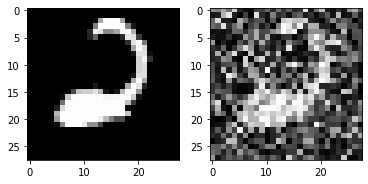

25  :  0.4940184949530248 25
50  :  0.4940184949530248 25
75  :  0.49405061100735703 25
100  :  0.49405061100735703 25
125  :  0.49405061100735703 25
150  :  0.49405061100735703 25
175  :  0.4940626230132733 25
200  :  0.4935062644985877 25
225  :  0.4938090552473973 25
250  :  0.49388988388298755 25
275  :  0.4941482428497017 25
300  :  0.4940496340058701 25
325  :  0.4940496340058701 25
350  :  0.49417355343953495 25
375  :  0.49417355343953495 25
400  :  0.49417355343953495 25
425  :  0.49417355343953495 25
450  :  0.49417355343953495 25
475  :  0.49417355343953495 25
500  :  0.4944497727693039 25
525  :  0.4944497727693039 25
550  :  0.4944497727693039 25
575  :  0.4944497727693039 25
600  :  0.4944736145607176 25
625  :  0.494505007782341 25
650  :  0.49451951307292535 25
675  :  0.49454653921112846 25
700  :  0.49456769096549 25
725  :  0.4945897465253667 25
750  :  0.4946095173215536 25
775  :  0.49461729131214344 25
800  :  0.49466491949496744 25
Time:  42.41165280342102  secon

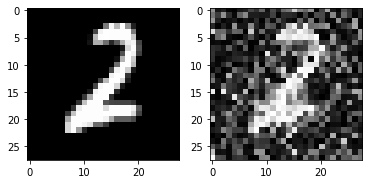

25  :  0.4581096023460851 25
50  :  0.49213790036642535 25
75  :  0.491104925933976 25
100  :  0.49209017349504397 25
125  :  0.49245933851816065 25
150  :  0.49316992091965783 25
175  :  0.49290091298899075 25
200  :  0.49290091298899075 25
225  :  0.49299750542538356 25
250  :  0.4931340009007578 25
275  :  0.4933060680431727 25
300  :  0.49335560901726194 25
325  :  0.4934060042358032 25
350  :  0.4934087663102676 25
375  :  0.4938931552144531 25
400  :  0.4939071333753239 25
425  :  0.4939071333753239 25
450  :  0.4939071333753239 25
475  :  0.4939071333753239 25
500  :  0.4939071333753239 25
525  :  0.4940203599083662 25
550  :  0.49403437958113816 25
575  :  0.4940393661654852 25
600  :  0.4940393661654852 25
625  :  0.4940393661654852 25
650  :  0.49405732853538564 25
675  :  0.49405498613940785 25
700  :  0.4940872283567231 25
725  :  0.4941238455850508 25
750  :  0.4942073792765716 25
775  :  0.4942188313538166 25
800  :  0.4942188313538166 25
825  :  0.4942520379057241 25
Tim

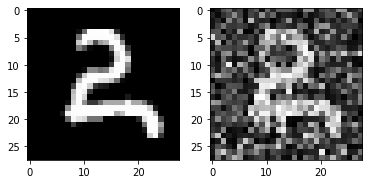

25  :  0.49344728894468226 25
50  :  0.49344728894468226 25
75  :  0.4939345243781082 25
100  :  0.4939737636698998 25
125  :  0.49398230860884146 25
150  :  0.4939598476123469 25
175  :  0.4939598476123469 25
200  :  0.4939598476123469 25
225  :  0.4939598476123469 25
250  :  0.4940995079423577 25
275  :  0.4940995079423577 25
300  :  0.49412661136147434 25
325  :  0.49418007903498523 25
350  :  0.494213164711822 25
375  :  0.4942490439467521 25
400  :  0.49447980434329236 25
425  :  0.4945375875064547 25
450  :  0.49454406410318924 25
475  :  0.49454406410318924 25
500  :  0.4945680062743911 25
525  :  0.4945711942317614 25
550  :  0.4945711942317614 25
575  :  0.4945758954440597 25
600  :  0.49460081292751945 25
625  :  0.49460075339315374 25
650  :  0.4946526980093964 25
675  :  0.4946526980093964 25
700  :  0.494702534776708 25
725  :  0.4947080518873491 25
750  :  0.4947312766463268 25
775  :  0.49473466269138555 25
800  :  0.49474367148535014 25
Time:  42.40454459190369  seconds

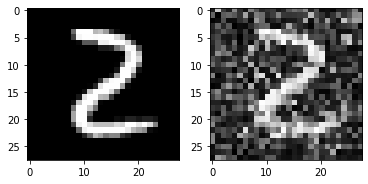

25  :  0.4484744679633803 25
50  :  0.49272044285862404 25
75  :  0.49333073435489755 25
100  :  0.4935096898055514 25
125  :  0.49370450296254315 25
150  :  0.49370450296254315 25
175  :  0.49412335869230833 25
200  :  0.49412335869230833 25
225  :  0.49412335869230833 25
250  :  0.49412335869230833 25
275  :  0.49436567931381054 25
300  :  0.49436567931381054 25
325  :  0.49436567931381054 25
350  :  0.49441707742018964 25
375  :  0.4944694873746246 25
400  :  0.49447328192771134 25
425  :  0.49453589220596494 25
450  :  0.49452781040714183 25
475  :  0.4945304823059559 25
500  :  0.49452781040714183 25
525  :  0.49459226339605983 25
550  :  0.4946589549002799 25
575  :  0.4946719918915953 25
600  :  0.4947056614178427 25
625  :  0.49471590163166995 25
650  :  0.4947595749404064 25
675  :  0.49478262586171845 25
700  :  0.49482136483063816 25
725  :  0.49483520378534684 25
750  :  0.4949019019961427 25
775  :  0.49490173144185823 25
800  :  0.49490173144185823 25
825  :  0.4949202282

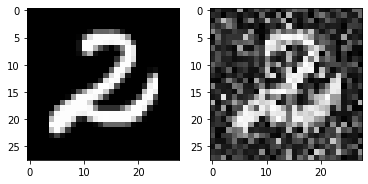

25  :  0.4642419428635657 25
50  :  0.47798572935828365 25
75  :  0.4930421716552975 25
100  :  0.4930255890249735 25
125  :  0.4932126673454653 25
150  :  0.49324170133004014 25
175  :  0.49324170133004014 25
200  :  0.49324170133004014 25
225  :  0.49324170133004014 25
250  :  0.4932627130206121 25
275  :  0.4933741104439141 25
300  :  0.4937418744102196 25
325  :  0.4933741104439141 25
350  :  0.4933741104439141 25
375  :  0.4933741104439141 25
400  :  0.49366706658380766 25
425  :  0.49383417522835316 25
450  :  0.4937885763483002 25
475  :  0.49381783215483177 25
500  :  0.49381783215483177 25
525  :  0.49381783215483177 25
550  :  0.49395648386390456 25
575  :  0.49395648386390456 25
600  :  0.49395648386390456 25
625  :  0.49395648386390456 25
650  :  0.49395648386390456 25
675  :  0.493958292304718 25
700  :  0.49403655007829483 25
725  :  0.49405681534727197 25
750  :  0.49412807761916927 25
775  :  0.4941669974805237 25
800  :  0.4941763499153158 25
825  :  0.4942196549834792

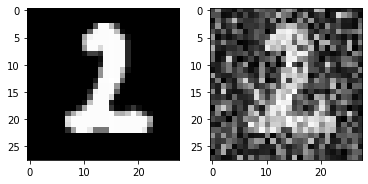

25  :  0.49156472819428476 25
50  :  0.49156472819428476 25
75  :  0.4932365862870252 25
100  :  0.49367261599108425 25
125  :  0.49362262244879795 25
150  :  0.49366911466838037 25
175  :  0.49366911466838037 25
200  :  0.49377781372178786 25
225  :  0.49395712888932863 25
250  :  0.49395712888932863 25
275  :  0.49395712888932863 25
300  :  0.49395712888932863 25
325  :  0.49395712888932863 25
350  :  0.49395712888932863 25
375  :  0.4939875508816313 25
400  :  0.4939875508816313 25
425  :  0.4939875508816313 25
450  :  0.4939875508816313 25
475  :  0.4939875508816313 25
500  :  0.4940520830789184 25
525  :  0.49408538493195786 25
550  :  0.49414366437415 25
575  :  0.4941735293254891 25
600  :  0.4941815759111557 25
625  :  0.4942827016680958 25
650  :  0.4943443525215593 25
675  :  0.49435032263944373 25
700  :  0.49435309974444497 25
725  :  0.49439647050074376 25
750  :  0.49439510150033866 25
775  :  0.49442482774359403 25
800  :  0.494441332833271 25
Time:  41.73759841918945  s

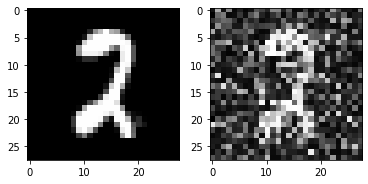

25  :  0.20559736624196587 25
50  :  0.48901479582497837 25
75  :  0.49238263128963516 25
100  :  0.4928457006237223 25
125  :  0.4933501115406305 25
150  :  0.4933501115406305 25
175  :  0.4933501115406305 25
200  :  0.4933501115406305 25
225  :  0.4933501115406305 25
250  :  0.4933501115406305 25
275  :  0.4933501115406305 25
300  :  0.4933501115406305 25
325  :  0.4933501115406305 25
350  :  0.493390883464012 25
375  :  0.493663481177665 25
400  :  0.493663481177665 25
425  :  0.493663481177665 25
450  :  0.4940210698777518 25
475  :  0.4939752047245337 25
500  :  0.4940352970625286 25
525  :  0.4941485001273669 25
550  :  0.494209153940419 25
575  :  0.494238977120524 25
600  :  0.494260460059426 25
625  :  0.494270289479799 25
650  :  0.494270289479799 25
675  :  0.4943162565775362 25
700  :  0.4943093692794159 25
725  :  0.49441283693414223 25
750  :  0.49441283693414223 25
775  :  0.4944555503409076 25
800  :  0.49450179204274836 25
825  :  0.4944988536430674 25
Time:  43.522709

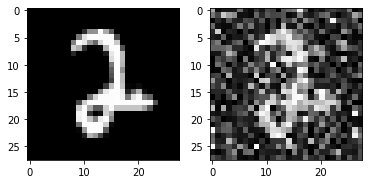

25  :  0.4766482516451261 25
50  :  0.492601219247085 25
75  :  0.48703451734774755 25
100  :  0.49222111751610503 25
125  :  0.49248886009839765 25
150  :  0.4930144160970937 25
175  :  0.49305511788279044 25
200  :  0.49305511788279044 25
225  :  0.49305511788279044 25
250  :  0.49305511788279044 25
275  :  0.49305511788279044 25
300  :  0.493490424277666 25
325  :  0.4933199032259288 25
350  :  0.4934568206681272 25
375  :  0.4937680165978261 25
400  :  0.4937572559381959 25
425  :  0.4937572559381959 25
450  :  0.4937572559381959 25
475  :  0.4937572559381959 25
500  :  0.4937572559381959 25
525  :  0.4937572559381959 25
550  :  0.4938206699897632 25
575  :  0.49381268896324754 25
600  :  0.49381268896324754 25
625  :  0.4940276456779287 25
650  :  0.4940276456779287 25
675  :  0.4940276456779287 25
700  :  0.4940276456779287 25
725  :  0.4940276456779287 25
750  :  0.49403111471908134 25
775  :  0.4940557137157758 25
800  :  0.4940557137157758 25
825  :  0.49406293020103054 25
Tim

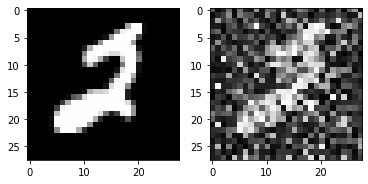

25  :  0.006320039730871488 25
50  :  0.3119502844091392 25
75  :  0.2737426030655782 25
100  :  0.4351394113991108 25
125  :  0.4212889222563593 25
150  :  0.428917631267022 25
175  :  0.491610131147555 25
200  :  0.49172534594918016 25
225  :  0.4923106734001112 25
250  :  0.49255595860496365 25
275  :  0.4922793460564892 25
300  :  0.4928325958167411 25
325  :  0.4924218028844977 25
350  :  0.4925948933246284 25
375  :  0.4925973290939107 25
400  :  0.4925977394463475 25
425  :  0.4925977394463475 25
450  :  0.4925977394463475 25
475  :  0.4925977394463475 25
500  :  0.4927220125827916 25
525  :  0.4927699190121745 25
550  :  0.4927699190121745 25
575  :  0.4929099198715926 25
600  :  0.4929020063432767 25
625  :  0.4929954077487967 25
650  :  0.4929954077487967 25
675  :  0.4929954077487967 25
700  :  0.4929954077487967 25
725  :  0.4931198602843525 25
750  :  0.4931233096951709 25
775  :  0.4931233096951709 25
800  :  0.4931233096951709 25
825  :  0.4931233096951709 25
850  :  0.4

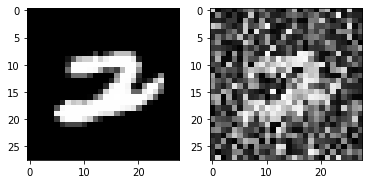

25  :  0.4949174760181149 25
50  :  0.49555276430908146 25
75  :  0.4954802565342856 25
100  :  0.4954802565342856 25
125  :  0.4954802565342856 25
150  :  0.4954802565342856 25
175  :  0.4954802565342856 25
200  :  0.4954802565342856 25
225  :  0.4954802565342856 25
250  :  0.4954802565342856 25
275  :  0.4954802565342856 25
300  :  0.4954802565342856 25
325  :  0.4954802565342856 25
350  :  0.4956294559177693 25
375  :  0.495637175630282 25
400  :  0.495637175630282 25
425  :  0.495637175630282 25
450  :  0.4956633846183066 25
475  :  0.4956633846183066 25
500  :  0.49572821670250794 25
525  :  0.4957282170148913 25
550  :  0.4957282170148913 25
575  :  0.4957282170148913 25
600  :  0.4957282170148913 25
625  :  0.4957282170148913 25
650  :  0.49574227433830825 25
675  :  0.49577466525037517 25
700  :  0.4958090290411255 25
725  :  0.4958277142636627 25
750  :  0.4958331150207223 25
775  :  0.4958635814111177 25
800  :  0.4958635814111177 25
Time:  41.60809278488159  seconds
Predicte

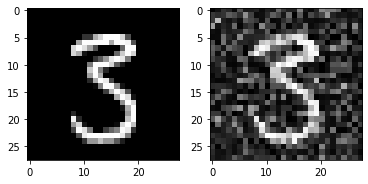

25  :  0.4932896917294705 25
50  :  0.49394890553519505 25
75  :  0.49428557592593747 25
100  :  0.49428557592593747 25
125  :  0.49428557592593747 25
150  :  0.49428557592593747 25
175  :  0.49428557592593747 25
200  :  0.49428557592593747 25
225  :  0.49428557592593747 25
250  :  0.49428557592593747 25
275  :  0.4943248898412948 25
300  :  0.49437509887610065 25
325  :  0.4944825779574745 25
350  :  0.49455330975710143 25
375  :  0.49455330975710143 25
400  :  0.49457007664426084 25
425  :  0.49466331582811607 25
450  :  0.4947652784321314 25
475  :  0.4947652784321314 25
500  :  0.4947729900436506 25
525  :  0.49478073475192064 25
550  :  0.4948166632512059 25
575  :  0.4948491077690703 25
600  :  0.4948491077690703 25
625  :  0.4948705722159348 25
650  :  0.494948965496826 25
675  :  0.4949784920564763 25
700  :  0.49499163097136817 25
725  :  0.49500492275410624 25
750  :  0.4950423861882117 25
775  :  0.49506526742204005 25
800  :  0.4950993598589502 25
Time:  41.53865694999695  

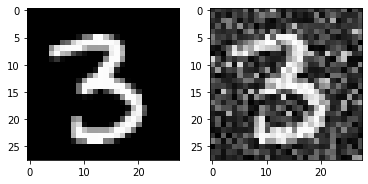

25  :  0.49123348733563393 25
50  :  0.491342138045269 25
75  :  0.4938430940057247 25
100  :  0.4938430940057247 25
125  :  0.4940267271923355 25
150  :  0.4940267271923355 25
175  :  0.4940267271923355 25
200  :  0.4940267271923355 25
225  :  0.4940267271923355 25
250  :  0.49430621364211563 25
275  :  0.4943743200878565 25
300  :  0.4943743200878565 25
325  :  0.4943743200878565 25
350  :  0.4943743200878565 25
375  :  0.4943743200878565 25
400  :  0.4943991463097784 25
425  :  0.4944589501746369 25
450  :  0.4944589501746369 25
475  :  0.4945120886504606 25
500  :  0.4945543850139877 25
525  :  0.4945536914976402 25
550  :  0.49460076120761565 25
575  :  0.4946150345370996 25
600  :  0.4946969992706931 25
625  :  0.4947276551583678 25
650  :  0.4947311836301476 25
675  :  0.4947362457837675 25
700  :  0.4947916607373298 25
725  :  0.4947932247269432 25
750  :  0.4947932247269432 25
775  :  0.49482262021194484 25
800  :  0.49482262021194484 25
Time:  40.993300914764404  seconds
Pred

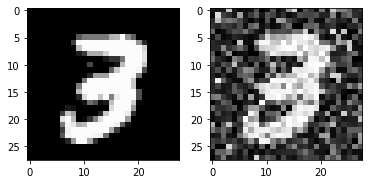

25  :  0.49282069370352877 25
50  :  0.49282069370352877 25
75  :  0.49328838515207196 25
100  :  0.4936507728097546 25
125  :  0.4936507728097546 25
150  :  0.4936507728097546 25
175  :  0.4936507728097546 25
200  :  0.4936507728097546 25
225  :  0.494214319727154 25
250  :  0.49434041738096207 25
275  :  0.49434041738096207 25
300  :  0.49434041738096207 25
325  :  0.49434041738096207 25
350  :  0.4943517185485622 25
375  :  0.49438513852513477 25
400  :  0.4944600755459144 25
425  :  0.49438513852513477 25
450  :  0.49446581143397517 25
475  :  0.4946154915233552 25
500  :  0.4946395330252902 25
525  :  0.4946395330252902 25
550  :  0.4946420533835611 25
575  :  0.4946557257608721 25
600  :  0.4946792631573716 25
625  :  0.49475011194377877 25
650  :  0.4947517830282135 25
675  :  0.4947529047128987 25
700  :  0.4947740106436754 25
725  :  0.49477341575803413 25
750  :  0.4948320720923821 25
775  :  0.4948320370766941 25
800  :  0.4948455912581436 25
Time:  40.61258125305176  second

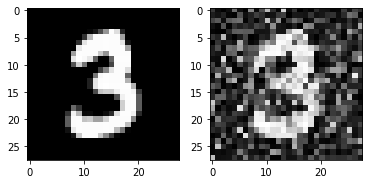

25  :  0.4884300707379691 25
50  :  0.49256043380597375 25
75  :  0.4942576755600647 25
100  :  0.4941131993699825 25
125  :  0.49421218967591857 25
150  :  0.49421218967591857 25
175  :  0.49421218967591857 25
200  :  0.49421218967591857 25
225  :  0.49437746046399933 25
250  :  0.49437746046399933 25
275  :  0.49437746046399933 25
300  :  0.49437746046399933 25
325  :  0.49437746046399933 25
350  :  0.49437746046399933 25
375  :  0.49437746046399933 25
400  :  0.4944950486469781 25
425  :  0.49457500840558305 25
450  :  0.49457500840558305 25
475  :  0.49457500840558305 25
500  :  0.49466852818091805 25
525  :  0.4947023955290051 25
550  :  0.49482842736906774 25
575  :  0.49482871198286615 25
600  :  0.4948727670136697 25
625  :  0.49492513764040297 25
650  :  0.49496500157331524 25
675  :  0.4949672252499283 25
700  :  0.4949671711973458 25
725  :  0.4949671711973458 25
750  :  0.4950140945917244 25
775  :  0.4950140945917244 25
800  :  0.49505746469184087 25
Time:  42.267050027847

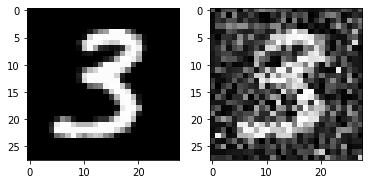

25  :  0.26271926205461854 25
50  :  0.40697517030565267 25
75  :  0.4937380918930691 25
100  :  0.49411834760622336 25
125  :  0.49411834760622336 25
150  :  0.49411834760622336 25
175  :  0.49411834760622336 25
200  :  0.49411834760622336 25
225  :  0.49411834760622336 25
250  :  0.49411834760622336 25
275  :  0.49411834760622336 25
300  :  0.49411834760622336 25
325  :  0.49411834760622336 25
350  :  0.49411834760622336 25
375  :  0.49411834760622336 25
400  :  0.49415849364740266 25
425  :  0.49416517453770187 25
450  :  0.4942526093254713 25
475  :  0.4942526093254713 25
500  :  0.4943591622210068 25
525  :  0.49435927564060644 25
550  :  0.49435927564060644 25
575  :  0.4943594545386497 25
600  :  0.4943871739336796 25
625  :  0.494448659174388 25
650  :  0.49446593788210025 25
675  :  0.49446593931074645 25
700  :  0.4945046167348824 25
725  :  0.49451133848312123 25
750  :  0.49451133848312123 25
775  :  0.49451133848312123 25
800  :  0.4945126912791028 25
825  :  0.49458067734

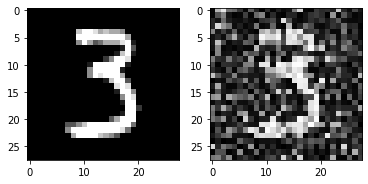

25  :  0.45249361034562885 25
50  :  0.4936733940574021 25
75  :  0.49191212897638703 25
100  :  0.4926439332684396 25
125  :  0.4930422559074725 25
150  :  0.49340091454696344 25
175  :  0.4933621869477447 25
200  :  0.4933621869477447 25
225  :  0.4933621869477447 25
250  :  0.4933621869477447 25
275  :  0.4933621869477447 25
300  :  0.493517709013812 25
325  :  0.4935724366391049 25
350  :  0.4936024251911466 25
375  :  0.4936024251911466 25
400  :  0.4936024251911466 25
425  :  0.4936024251911466 25
450  :  0.4938341400168274 25
475  :  0.4938341400168274 25
500  :  0.4938341400168274 25
525  :  0.4938341400168274 25
550  :  0.49387857052552875 25
575  :  0.4938964870959298 25
600  :  0.49400537309795384 25
625  :  0.49400537309795384 25
650  :  0.49400537309795384 25
675  :  0.49400537309795384 25
700  :  0.4940106845796965 25
725  :  0.49402003905226727 25
750  :  0.4940206596496255 25
775  :  0.49405451864710187 25
800  :  0.4940902637911649 25
825  :  0.49408899567772196 25
Tim

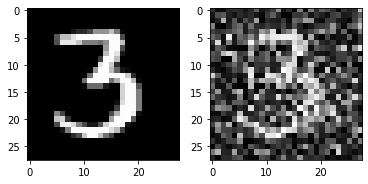

25  :  0.4610696489727415 25
50  :  0.4916726461264737 25
75  :  0.493586278759063 25
100  :  0.493696544611226 25
125  :  0.493696544611226 25
150  :  0.493696544611226 25
175  :  0.493696544611226 25
200  :  0.493696544611226 25
225  :  0.493696544611226 25
250  :  0.493696544611226 25
275  :  0.49375722814283546 25
300  :  0.4937762950040748 25
325  :  0.4937762950040748 25
350  :  0.4937762950040748 25
375  :  0.4937762950040748 25
400  :  0.4938639240784514 25
425  :  0.4938600208989879 25
450  :  0.4938600208989879 25
475  :  0.4938600208989879 25
500  :  0.4941159145239925 25
525  :  0.4941159145239925 25
550  :  0.4941159145239925 25
575  :  0.4941159145239925 25
600  :  0.49419308466382655 25
625  :  0.4942998421214455 25
650  :  0.4942998421214455 25
675  :  0.4942998421214455 25
700  :  0.4943005119427624 25
725  :  0.494387427648048 25
750  :  0.494387816376122 25
775  :  0.49446075817753293 25
800  :  0.49446071665294306 25
825  :  0.49446071665294306 25
Time:  41.85519385

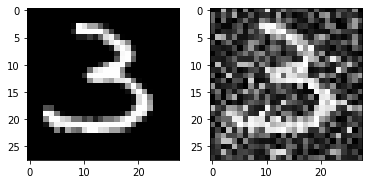

25  :  0.4927552012048018 25
50  :  0.4931725496472097 25
75  :  0.4938737197968785 25
100  :  0.4938737197968785 25
125  :  0.4938737197968785 25
150  :  0.4938737197968785 25
175  :  0.4938737197968785 25
200  :  0.4938737197968785 25
225  :  0.4938737197968785 25
250  :  0.49409272903912843 25
275  :  0.49409272903912843 25
300  :  0.49409272903912843 25
325  :  0.49409272903912843 25
350  :  0.49409272903912843 25
375  :  0.49409272903912843 25
400  :  0.4941027657223117 25
425  :  0.4941027657223117 25
450  :  0.4941027657223117 25
475  :  0.49416994447987683 25
500  :  0.4942184971465288 25
525  :  0.49426664980442614 25
550  :  0.49426565038403997 25
575  :  0.4943403624695437 25
600  :  0.4944478377251764 25
625  :  0.4944493354293113 25
650  :  0.4944493354293113 25
675  :  0.4944493354293113 25
700  :  0.4944493354293113 25
725  :  0.4944551776415777 25
750  :  0.4944749694764225 25
775  :  0.49451068531839426 25
800  :  0.49451500758317257 25
Time:  39.99418354034424  second

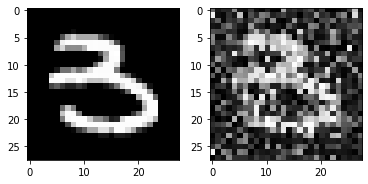

25  :  0.49383577280120483 25
50  :  0.49383577280120483 25
75  :  0.4944960453535281 25
100  :  0.49420292017906425 25
125  :  0.494650204475288 25
150  :  0.494650204475288 25
175  :  0.494650204475288 25
200  :  0.494650204475288 25
225  :  0.4947402431905807 25
250  :  0.4947625531805305 25
275  :  0.49480812041842515 25
300  :  0.49487024735104757 25
325  :  0.49494468960261545 25
350  :  0.49496690482911204 25
375  :  0.4949920267475096 25
400  :  0.49504228521779015 25
425  :  0.49507852812020614 25
450  :  0.49510845611617976 25
475  :  0.49517460148075537 25
500  :  0.49517662588035755 25
525  :  0.49519204001159517 25
550  :  0.4951927611485826 25
575  :  0.4952413163965211 25
600  :  0.4952527063106898 25
625  :  0.49526441863829124 25
650  :  0.4952928686573541 25
675  :  0.4952932142973915 25
700  :  0.49531643127088404 25
725  :  0.4953257559874857 25
750  :  0.49533071163112447 25
775  :  0.4953837463819016 25
800  :  0.495383767105198 25
Time:  40.21325063705444  second

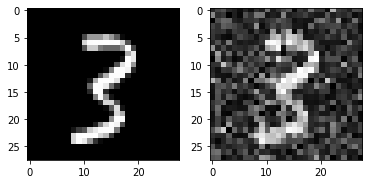

25  :  0.4936219143981239 25
50  :  0.4936219143981239 25
75  :  0.49380550186320155 25
100  :  0.49386395481151507 25
125  :  0.49386395481151507 25
150  :  0.4939168009603372 25
175  :  0.4941616764310554 25
200  :  0.4941616764310554 25
225  :  0.4941616764310554 25
250  :  0.4941616764310554 25
275  :  0.4941616764310554 25
300  :  0.4941616764310554 25
325  :  0.49422423088241935 25
350  :  0.494369435227959 25
375  :  0.49442946870399823 25
400  :  0.4945655109051701 25
425  :  0.4945752706689833 25
450  :  0.49475453680326903 25
475  :  0.49481301285955187 25
500  :  0.4948005536134588 25
525  :  0.4948005536134588 25
550  :  0.4948005536134588 25
575  :  0.4948005536134588 25
600  :  0.49484289345067733 25
625  :  0.49488213921060403 25
650  :  0.4949134462886515 25
675  :  0.4949117692367763 25
700  :  0.494970978471095 25
725  :  0.49501062203392265 25
750  :  0.4950364384683343 25
775  :  0.49505187534309203 25
800  :  0.4950536001381123 25
Time:  40.0418918132782  seconds
P

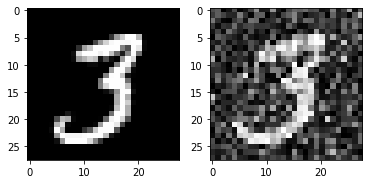

25  :  0.40764321297967043 25
50  :  0.44531145418597107 25
75  :  0.4934663390124999 25
100  :  0.49393257577966054 25
125  :  0.4947231991088679 25
150  :  0.4945405636659055 25
175  :  0.4945405636659055 25
200  :  0.4945405636659055 25
225  :  0.4945405636659055 25
250  :  0.4945405636659055 25
275  :  0.4945405636659055 25
300  :  0.4945405636659055 25
325  :  0.4945405636659055 25
350  :  0.4945405636659055 25
375  :  0.4945405636659055 25
400  :  0.4945405636659055 25
425  :  0.4945405636659055 25
450  :  0.4945970022786197 25
475  :  0.49467809699826937 25
500  :  0.4946900169164527 25
525  :  0.49469774872865113 25
550  :  0.49469774872865113 25
575  :  0.49469774872865113 25
600  :  0.49469774872865113 25
625  :  0.49480419233304873 25
650  :  0.49480419233304873 25
675  :  0.49480419233304873 25
700  :  0.49483808505998694 25
725  :  0.49486837578372844 25
750  :  0.4949376243604765 25
775  :  0.49493852707716024 25
800  :  0.49495357929187195 25
825  :  0.49496140059450777 

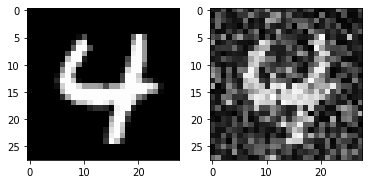

25  :  -0.0674447239294231 25
50  :  0.2794466719369997 25
75  :  0.4941696766874266 25
100  :  0.49275357950602194 25
125  :  0.4936080189935039 25
150  :  0.4945033060786237 25
175  :  0.49427163563181303 25
200  :  0.49427163563181303 25
225  :  0.49427163563181303 25
250  :  0.49453633120712204 25
275  :  0.49453744726209353 25
300  :  0.49453744726209353 25
325  :  0.49453744726209353 25
350  :  0.49453744726209353 25
375  :  0.49453744726209353 25
400  :  0.49453744726209353 25
425  :  0.49453744726209353 25
450  :  0.49453744726209353 25
475  :  0.4945530243911113 25
500  :  0.49465065482189075 25
525  :  0.49465065482189075 25
550  :  0.49465065482189075 25
575  :  0.49465065482189075 25
600  :  0.49478170396945653 25
625  :  0.49480940537225887 25
650  :  0.4948895338124129 25
675  :  0.49488621590936477 25
700  :  0.4949025323702116 25
725  :  0.49490304024147974 25
750  :  0.49490304024147974 25
775  :  0.4949061944227088 25
800  :  0.4949392481476833 25
825  :  0.4949420084

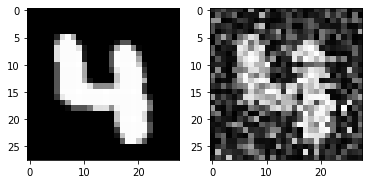

25  :  0.48910777488249024 25
50  :  0.4918739708797032 25
75  :  0.4924426957729162 25
100  :  0.49282876851332713 25
125  :  0.4930750997121359 25
150  :  0.49332081476120504 25
175  :  0.4933928246557772 25
200  :  0.4933928246557772 25
225  :  0.4933928246557772 25
250  :  0.49364325348881516 25
275  :  0.493653876412186 25
300  :  0.49368577873320757 25
325  :  0.49374835847534554 25
350  :  0.49374835847534554 25
375  :  0.49374835847534554 25
400  :  0.4937982496837105 25
425  :  0.49384437796320624 25
450  :  0.4939006200825429 25
475  :  0.49407151673515376 25
500  :  0.4940791911386935 25
525  :  0.4940791911386935 25
550  :  0.4941053698482659 25
575  :  0.4941053698482659 25
600  :  0.49412850568401867 25
625  :  0.49412850635886046 25
650  :  0.49412850635886046 25
675  :  0.49412866987932563 25
700  :  0.49414723073071876 25
725  :  0.49416625613336745 25
750  :  0.49419341306409026 25
775  :  0.49419341306409026 25
800  :  0.49419341306409026 25
Time:  39.89466214179993 

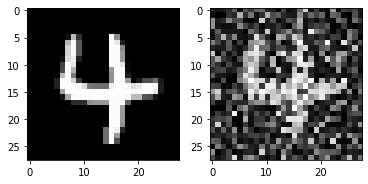

25  :  0.49337794621138853 25
50  :  0.4935869133096722 25
75  :  0.4935442217662767 25
100  :  0.49356155440708877 25
125  :  0.49356155440708877 25
150  :  0.49356155440708877 25
175  :  0.49363020735553137 25
200  :  0.4939211661388905 25
225  :  0.49392516162294503 25
250  :  0.4939890892786996 25
275  :  0.4940969652466116 25
300  :  0.49422868469612047 25
325  :  0.4943280197527962 25
350  :  0.49444114984717774 25
375  :  0.4944183769734556 25
400  :  0.4944552430326908 25
425  :  0.4944523187006261 25
450  :  0.49460945129274125 25
475  :  0.49466158044573605 25
500  :  0.49469763392954375 25
525  :  0.4947908661258791 25
550  :  0.49479176160768545 25
575  :  0.49479176160768545 25
600  :  0.4948120287767674 25
625  :  0.4948260947050304 25
650  :  0.4948454778507644 25
675  :  0.494859644945956 25
700  :  0.4948619596297333 25
725  :  0.4948701727369032 25
750  :  0.4948701727369032 25
775  :  0.49490911904978974 25
800  :  0.49490925183474643 25
Time:  40.98894023895264  sec

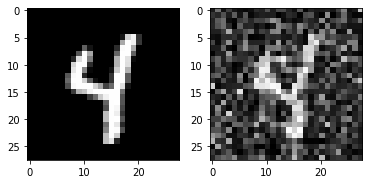

25  :  0.4914860571753915 25
50  :  0.4929860913638905 25
75  :  0.49405259102389726 25
100  :  0.4942316090796782 25
125  :  0.4942316090796782 25
150  :  0.4948848989960462 25
175  :  0.4951120290663115 25
200  :  0.4951120290663115 25
225  :  0.4951120290663115 25
250  :  0.4951120290663115 25
275  :  0.4951120290663115 25
300  :  0.4951120290663115 25
325  :  0.4951120290663115 25
350  :  0.4951120290663115 25
375  :  0.4951120290663115 25
400  :  0.4951120290663115 25
425  :  0.4951120290663115 25
450  :  0.4951406554059109 25
475  :  0.4951442548078808 25
500  :  0.49520185718181836 25
525  :  0.49520185718181836 25
550  :  0.49520185718181836 25
575  :  0.49520185718181836 25
600  :  0.49520185718181836 25
625  :  0.49527529126984576 25
650  :  0.4952742725540707 25
675  :  0.4952742725540707 25
700  :  0.4952808265474013 25
725  :  0.49527879689261173 25
750  :  0.49527879689261173 25
775  :  0.49527879689261173 25
800  :  0.49529082862060336 25
Time:  39.99313569068909  second

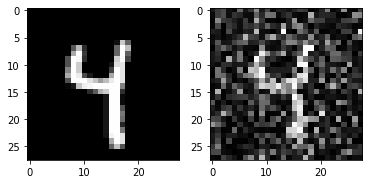

25  :  0.49487726987575026 25
50  :  0.49487726987575026 25
75  :  0.49510039113434834 25
100  :  0.4951397165759931 25
125  :  0.4951970739367038 25
150  :  0.49532835010604825 25
175  :  0.49532835010604825 25
200  :  0.49532835010604825 25
225  :  0.4953934840504286 25
250  :  0.49539599383223676 25
275  :  0.4955112403114012 25
300  :  0.49551048364265293 25
325  :  0.49551048364265293 25
350  :  0.495595011327871 25
375  :  0.49559449525882654 25
400  :  0.49559449525882654 25
425  :  0.4957101971955945 25
450  :  0.4956975867750049 25
475  :  0.49577075408290405 25
500  :  0.49578905496354897 25
525  :  0.4958344395276229 25
550  :  0.49582736286253515 25
575  :  0.4958885637135793 25
600  :  0.495890121091989 25
625  :  0.4959201852445455 25
650  :  0.4959203120710586 25
675  :  0.4959203120710586 25
700  :  0.4959268665412748 25
725  :  0.495931462410446 25
750  :  0.49594193873582304 25
775  :  0.49594193873582304 25
800  :  0.49595295216125973 25
Time:  40.296836853027344  se

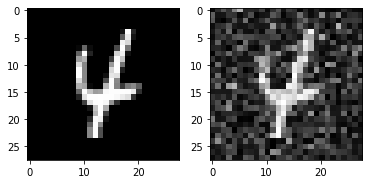

25  :  0.49415300044451094 25
50  :  0.49415300044451094 25
75  :  0.4939803027151818 25
100  :  0.4939803027151818 25
125  :  0.4939803027151818 25
150  :  0.4939803027151818 25
175  :  0.4939803027151818 25
200  :  0.49408522632103247 25
225  :  0.49408522632103247 25
250  :  0.4942067996623385 25
275  :  0.4942067996623385 25
300  :  0.4942067996623385 25
325  :  0.4942485123636935 25
350  :  0.49447109744792783 25
375  :  0.49447109744792783 25
400  :  0.49447109744792783 25
425  :  0.4945651833610978 25
450  :  0.4945651833610978 25
475  :  0.494590635415135 25
500  :  0.494590635415135 25
525  :  0.494590635415135 25
550  :  0.49469387203019316 25
575  :  0.4947867268179756 25
600  :  0.4948657960665304 25
625  :  0.4948657960665304 25
650  :  0.4948657960665304 25
675  :  0.4948657960665304 25
700  :  0.4949519398494575 25
725  :  0.49501101932898345 25
750  :  0.4950142915560653 25
775  :  0.4950151737156843 25
800  :  0.49507196662476466 25
Time:  39.79076266288757  seconds
Pr

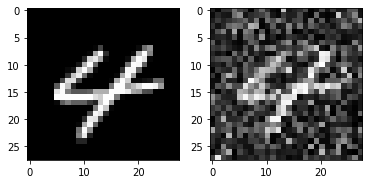

25  :  0.4919991043916016 25
50  :  0.4919991043916016 25
75  :  0.49344807008965696 25
100  :  0.49344807008965696 25
125  :  0.4935100824286439 25
150  :  0.4935100824286439 25
175  :  0.49355789808226985 25
200  :  0.49355789808226985 25
225  :  0.49355789808226985 25
250  :  0.49355789808226985 25
275  :  0.49355789808226985 25
300  :  0.4936611674224851 25
325  :  0.49408231059516045 25
350  :  0.49408231059516045 25
375  :  0.49408231059516045 25
400  :  0.4941065702481182 25
425  :  0.49416701378788197 25
450  :  0.4942582160070719 25
475  :  0.4942582160070719 25
500  :  0.49428444558484336 25
525  :  0.49432071749199835 25
550  :  0.49439069297189436 25
575  :  0.49439069297189436 25
600  :  0.4944360792183177 25
625  :  0.4944574469591755 25
650  :  0.4944751151980587 25
675  :  0.4944751151980587 25
700  :  0.4944785748052308 25
725  :  0.49447993327972994 25
750  :  0.49450181045854785 25
775  :  0.4945041865569153 25
800  :  0.494522375661829 25
Time:  39.74417567253113  s

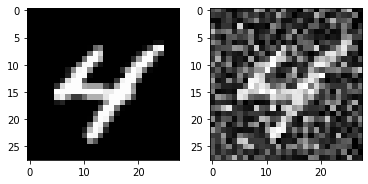

25  :  0.49465539797610836 25
50  :  0.49465539797610836 25
75  :  0.4948104965001824 25
100  :  0.49493491947263896 25
125  :  0.494973142222068 25
150  :  0.49498668550480057 25
175  :  0.49501388865248186 25
200  :  0.49501388865248186 25
225  :  0.4950376848938203 25
250  :  0.49514800015544375 25
275  :  0.49514800015544375 25
300  :  0.49517600249248833 25
325  :  0.4952981737783922 25
350  :  0.49540371603185235 25
375  :  0.49540371603185235 25
400  :  0.4955389366468787 25
425  :  0.4955389366468787 25
450  :  0.4955389366468787 25
475  :  0.49554817488845343 25
500  :  0.4955517435051797 25
525  :  0.49559445747987896 25
550  :  0.4956610291123313 25
575  :  0.4956610291123313 25
600  :  0.49566714014080515 25
625  :  0.4956823407186206 25
650  :  0.49571751823909044 25
675  :  0.49572116232607566 25
700  :  0.49572116232607566 25
725  :  0.49572116232607566 25
750  :  0.4957320562752978 25
775  :  0.49575191508779637 25
800  :  0.49575191508779637 25
Time:  41.22797894477844

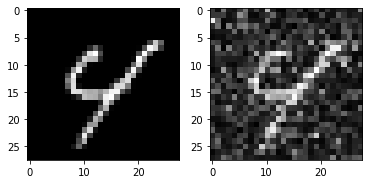

25  :  0.392905198254834 25
50  :  0.49282691001241563 25
75  :  0.4937699004778886 25
100  :  0.49391719927128414 25
125  :  0.49390505793018324 25
150  :  0.49390505793018324 25
175  :  0.4939281467657951 25
200  :  0.4939605837932969 25
225  :  0.4939697466103448 25
250  :  0.493994060538276 25
275  :  0.4940497526014112 25
300  :  0.49408228045579705 25
325  :  0.49424505111567063 25
350  :  0.49439472404320445 25
375  :  0.4944302117687473 25
400  :  0.4944088090603759 25
425  :  0.49454786637888926 25
450  :  0.4944219446709249 25
475  :  0.494603744519376 25
500  :  0.4946296222413865 25
525  :  0.49462854635561126 25
550  :  0.494646465093705 25
575  :  0.49464298563479975 25
600  :  0.4946432439392289 25
625  :  0.49466037701733473 25
650  :  0.49467035123021813 25
675  :  0.4946750342619457 25
700  :  0.4946985725123757 25
725  :  0.49469858571712566 25
750  :  0.49470686362079175 25
775  :  0.49471331424587883 25
800  :  0.4947150518569592 25
825  :  0.4947280576202874 25
Ti

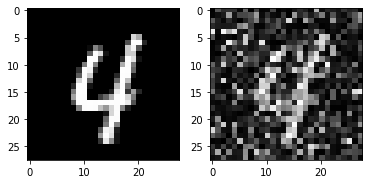

25  :  0.43652724836329526 25
50  :  0.4930047216565419 25
75  :  0.49322889706657924 25
100  :  0.49322889706657924 25
125  :  0.49322889706657924 25
150  :  0.4932425646393595 25
175  :  0.4934903691234024 25
200  :  0.4937112651515088 25
225  :  0.4937112651515088 25
250  :  0.4937112651515088 25
275  :  0.49376266170210714 25
300  :  0.49379152846304597 25
325  :  0.49392507947255904 25
350  :  0.49394371511901997 25
375  :  0.49397264348739317 25
400  :  0.49425135496537126 25
425  :  0.49425135496537126 25
450  :  0.49425135496537126 25
475  :  0.49425135496537126 25
500  :  0.49425135496537126 25
525  :  0.49432284906874724 25
550  :  0.49432244119776336 25
575  :  0.49432244119776336 25
600  :  0.49438727858370035 25
625  :  0.4943876839722928 25
650  :  0.4943876839722928 25
675  :  0.4943876839722928 25
700  :  0.4943876839722928 25
725  :  0.4943876839722928 25
750  :  0.4943876839722928 25
775  :  0.4943876839722928 25
800  :  0.4943876839722928 25
825  :  0.494387683972292

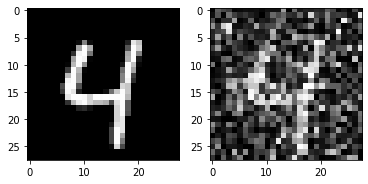

25  :  0.49370626626449243 25
50  :  0.49384172664127535 25
75  :  0.49399098099701927 25
100  :  0.49399098099701927 25
125  :  0.49399098099701927 25
150  :  0.49399098099701927 25
175  :  0.4940318172220073 25
200  :  0.49399098099701927 25
225  :  0.49399098099701927 25
250  :  0.49399098099701927 25
275  :  0.494112038871438 25
300  :  0.49399098099701927 25
325  :  0.49399098099701927 25
350  :  0.49399098099701927 25
375  :  0.49399098099701927 25
400  :  0.49399098099701927 25
425  :  0.49399098099701927 25
450  :  0.49399098099701927 25
475  :  0.49399098099701927 25
500  :  0.49399098099701927 25
525  :  0.49399098099701927 25
550  :  0.49399098099701927 25
575  :  0.49399098099701927 25
600  :  0.49399098099701927 25
625  :  0.49399098099701927 25
650  :  0.49399098099701927 25
675  :  0.49399098099701927 25
700  :  0.49399098099701927 25
725  :  0.49399098099701927 25
750  :  0.49399098099701927 25
775  :  0.49399098099701927 25
800  :  0.49399098099701927 25
Time:  39.8958

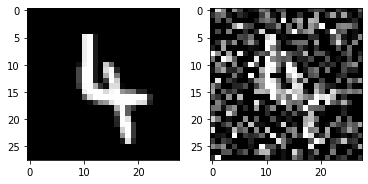

25  :  0.49433075009508604 25
50  :  0.49433075009508604 25
75  :  0.4945887739221429 25
100  :  0.4945887739221429 25
125  :  0.4945887739221429 25
150  :  0.4945887739221429 25
175  :  0.4945887739221429 25
200  :  0.49473667345110045 25
225  :  0.4946603944505858 25
250  :  0.4946603944505858 25
275  :  0.4946603944505858 25
300  :  0.4946614157478534 25
325  :  0.49469829743627786 25
350  :  0.49469829743627786 25
375  :  0.49471130890673287 25
400  :  0.49477648369639793 25
425  :  0.4947823631243403 25
450  :  0.4947855681827755 25
475  :  0.4947855681827755 25
500  :  0.4947855681827755 25
525  :  0.49497439260370457 25
550  :  0.49497439260370457 25
575  :  0.49497439260370457 25
600  :  0.49497439260370457 25
625  :  0.49497439260370457 25
650  :  0.4950971557785676 25
675  :  0.495105676348282 25
700  :  0.495105676348282 25
725  :  0.495105676348282 25
750  :  0.495105676348282 25
775  :  0.495105676348282 25
800  :  0.4951096147791517 25
Time:  40.79745864868164  seconds
Pr

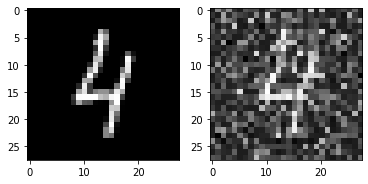

25  :  0.49523149875472655 25
50  :  0.49523149875472655 25
75  :  0.49523149875472655 25
100  :  0.49523149875472655 25
125  :  0.49523149875472655 25
150  :  0.4952877712741936 25
175  :  0.49523149875472655 25
200  :  0.4958127568246824 25
225  :  0.4958482808147133 25
250  :  0.4958482808147133 25
275  :  0.4958482808147133 25
300  :  0.4958482808147133 25
325  :  0.4958482808147133 25
350  :  0.49595544003353326 25
375  :  0.49595544003353326 25
400  :  0.49595544003353326 25
425  :  0.49595544003353326 25
450  :  0.49595544003353326 25
475  :  0.49595544003353326 25
500  :  0.49595544003353326 25
525  :  0.49599746390853316 25
550  :  0.49599703152074415 25
575  :  0.49599703152074415 25
600  :  0.4960374402722989 25
625  :  0.4960374402722989 25
650  :  0.4960374402722989 25
675  :  0.4960374402722989 25
700  :  0.4960424831203669 25
725  :  0.4960542856360676 25
750  :  0.4960614404196872 25
775  :  0.49607298707341924 25
800  :  0.49608497311528954 25
Time:  40.94312334060669 

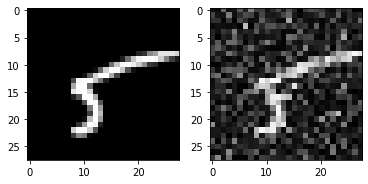

25  :  0.4931826005435388 25
50  :  0.4931826005435388 25
75  :  0.4942442985974614 25
100  :  0.494351516957601 25
125  :  0.494351516957601 25
150  :  0.494351516957601 25
175  :  0.49435711176696345 25
200  :  0.4943905523116213 25
225  :  0.4943905523116213 25
250  :  0.4943905523116213 25
275  :  0.494425268058935 25
300  :  0.494425268058935 25
325  :  0.494425268058935 25
350  :  0.494450401581253 25
375  :  0.494450401581253 25
400  :  0.49479089572143814 25
425  :  0.4947785022539949 25
450  :  0.4947785022539949 25
475  :  0.4947785022539949 25
500  :  0.49482765992390754 25
525  :  0.49483291168148924 25
550  :  0.49483291168148924 25
575  :  0.49486648331382016 25
600  :  0.4949285475646687 25
625  :  0.4949806500444597 25
650  :  0.4949851139181145 25
675  :  0.4949851139181145 25
700  :  0.49499088964511156 25
725  :  0.494991222017685 25
750  :  0.49504490980635035 25
775  :  0.4950726974128944 25
800  :  0.49507266762033786 25
Time:  39.84457015991211  seconds
Predicted

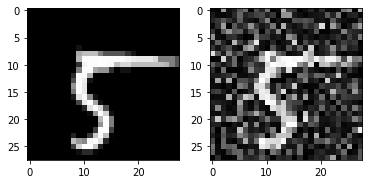

25  :  0.49476859929907907 25
50  :  0.49476859929907907 25
75  :  0.49476859929907907 25
100  :  0.4948144323172326 25
125  :  0.4947702181670078 25
150  :  0.4947702181670078 25
175  :  0.4947702181670078 25
200  :  0.4947796680534303 25
225  :  0.4947702181670078 25
250  :  0.49481550226969406 25
275  :  0.49485764825932615 25
300  :  0.49492190239047995 25
325  :  0.4949499149583187 25
350  :  0.49492190239047995 25
375  :  0.49503024397793105 25
400  :  0.49503996537710343 25
425  :  0.49506619830713045 25
450  :  0.49507421131859025 25
475  :  0.49507421131859025 25
500  :  0.49507421131859025 25
525  :  0.49507421131859025 25
550  :  0.49507421131859025 25
575  :  0.4951028620915043 25
600  :  0.49521641419410517 25
625  :  0.4953782719434665 25
650  :  0.4953790321968864 25
675  :  0.4953790321968864 25
700  :  0.4953790321968864 25
725  :  0.4953790321968864 25
750  :  0.4953790321968864 25
775  :  0.4953790321968864 25
800  :  0.4953790321968864 25
Time:  40.740678548812866  

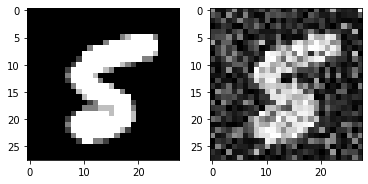

25  :  0.4880648132449482 25
50  :  0.49233943603685953 25
75  :  0.4937944060904287 25
100  :  0.49345454665319244 25
125  :  0.4937040270187604 25
150  :  0.49378321480278936 25
175  :  0.49380654166913723 25
200  :  0.4938092986871372 25
225  :  0.49380942769754316 25
250  :  0.49380942769754316 25
275  :  0.49392602308056216 25
300  :  0.4940003279578657 25
325  :  0.49405385138782737 25
350  :  0.49405385138782737 25
375  :  0.4941214712640969 25
400  :  0.49434825537456323 25
425  :  0.49434885997102984 25
450  :  0.49434885997102984 25
475  :  0.4943504576593874 25
500  :  0.4943504576593874 25
525  :  0.4944220467930264 25
550  :  0.49442560643848754 25
575  :  0.49442560643848754 25
600  :  0.4944709658889404 25
625  :  0.49447101629739726 25
650  :  0.49447101629739726 25
675  :  0.49448113906576024 25
700  :  0.4944959446294277 25
725  :  0.494568181029915 25
750  :  0.494570955607706 25
775  :  0.49461786373197464 25
800  :  0.4946226351875791 25
Time:  41.621264934539795  

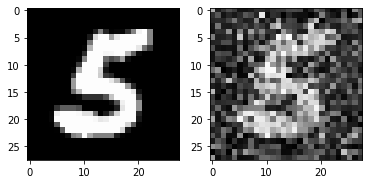

25  :  0.4896697999865972 25
50  :  0.4924824780945067 25
75  :  0.4930681268292636 25
100  :  0.49329379464895917 25
125  :  0.49354525094344387 25
150  :  0.4936288041772286 25
175  :  0.4936288041772286 25
200  :  0.4936416770035496 25
225  :  0.4937575956954944 25
250  :  0.4937575956954944 25
275  :  0.49409708458797297 25
300  :  0.4941803579265263 25
325  :  0.49419303068909076 25
350  :  0.49419246136266587 25
375  :  0.49419246136266587 25
400  :  0.49432136137949173 25
425  :  0.4943270347691514 25
450  :  0.4943270347691514 25
475  :  0.4943270347691514 25
500  :  0.4943888899156919 25
525  :  0.49439180597174925 25
550  :  0.4944034241760063 25
575  :  0.494462712875574 25
600  :  0.49451233797535243 25
625  :  0.49451225476434424 25
650  :  0.49452700052914 25
675  :  0.49452690143106104 25
700  :  0.49453501048479687 25
725  :  0.4945987528472735 25
750  :  0.49459999374109487 25
775  :  0.4946137367534306 25
800  :  0.49463447742772526 25
Time:  41.27026677131653  second

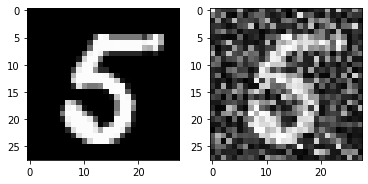

25  :  0.4914105690216727 25
50  :  0.49246241223051535 25
75  :  0.4933024850776339 25
100  :  0.4936700208631565 25
125  :  0.4943534229525273 25
150  :  0.49453346950100996 25
175  :  0.49453346950100996 25
200  :  0.49453346950100996 25
225  :  0.49453346950100996 25
250  :  0.49453346950100996 25
275  :  0.49453346950100996 25
300  :  0.49453346950100996 25
325  :  0.49455591258445547 25
350  :  0.49453346950100996 25
375  :  0.49453346950100996 25
400  :  0.49453346950100996 25
425  :  0.4946276089675757 25
450  :  0.49462808164600547 25
475  :  0.4947583184467636 25
500  :  0.4947860667568246 25
525  :  0.49479347132265583 25
550  :  0.49479347132265583 25
575  :  0.49479347132265583 25
600  :  0.49479347132265583 25
625  :  0.4948548149024068 25
650  :  0.4948462894572287 25
675  :  0.49494427292312354 25
700  :  0.4950301007269752 25
725  :  0.49508405619322077 25
750  :  0.4950895977477663 25
775  :  0.495100852583602 25
800  :  0.49516134471118634 25
Time:  43.55500912666321

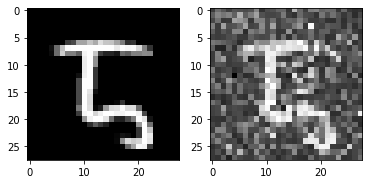

25  :  0.4949281843507674 25
50  :  0.49507734691588395 25
75  :  0.49512711812107735 25
100  :  0.49512711812107735 25
125  :  0.49512711812107735 25
150  :  0.49512711812107735 25
175  :  0.49522096766289986 25
200  :  0.49518822133436075 25
225  :  0.49544293197633765 25
250  :  0.49544293197633765 25
275  :  0.49544293197633765 25
300  :  0.49544293197633765 25
325  :  0.49544293197633765 25
350  :  0.49547645274137214 25
375  :  0.49548002892088683 25
400  :  0.4955900123387057 25
425  :  0.4955904330921927 25
450  :  0.49573156019242576 25
475  :  0.49573289748448884 25
500  :  0.49573578522875017 25
525  :  0.4957341422691816 25
550  :  0.4957341422691816 25
575  :  0.4957341422691816 25
600  :  0.4957341422691816 25
625  :  0.495773826858845 25
650  :  0.49581934615880346 25
675  :  0.4958224661730882 25
700  :  0.4958396501676153 25
725  :  0.49584513564460725 25
750  :  0.49584513564460725 25
775  :  0.4958618781369264 25
800  :  0.4958704198784051 25
Time:  45.29042911529541

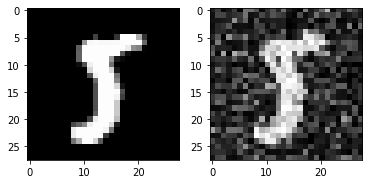

25  :  0.49467191714701786 25
50  :  0.49467191714701786 25
75  :  0.49483152840696054 25
100  :  0.49483152840696054 25
125  :  0.49483152840696054 25
150  :  0.49483152840696054 25
175  :  0.49483152840696054 25
200  :  0.49483152840696054 25
225  :  0.49483152840696054 25
250  :  0.4948586979678804 25
275  :  0.4951922195084883 25
300  :  0.49517288054915154 25
325  :  0.49517288054915154 25
350  :  0.49517288054915154 25
375  :  0.49519520643019366 25
400  :  0.49519520643019366 25
425  :  0.4952906759103373 25
450  :  0.4952906759103373 25
475  :  0.4952906759103373 25
500  :  0.4952906759103373 25
525  :  0.4953323152935155 25
550  :  0.4953323152935155 25
575  :  0.4953323152935155 25
600  :  0.4953589743005548 25
625  :  0.4953589459293031 25
650  :  0.4954167538042845 25
675  :  0.49549072170435177 25
700  :  0.4955036935582211 25
725  :  0.49550376598007967 25
750  :  0.4955203939650265 25
775  :  0.4955211968056727 25
800  :  0.4955372278044724 25
Time:  43.528908491134644  

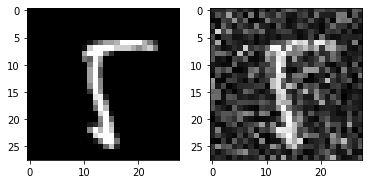

25  :  0.4827305659938179 25
50  :  0.4937064308631085 25
75  :  0.4931127504363788 25
100  :  0.493614243311439 25
125  :  0.4938190915247462 25
150  :  0.4938190915247462 25
175  :  0.4939602896624445 25
200  :  0.494044766580956 25
225  :  0.494044766580956 25
250  :  0.494044766580956 25
275  :  0.4940962392776906 25
300  :  0.4941072541937198 25
325  :  0.49427868226666005 25
350  :  0.49430513847623164 25
375  :  0.4943862560586194 25
400  :  0.49439003764570855 25
425  :  0.4943965251167272 25
450  :  0.49444734301554233 25
475  :  0.49450900587091823 25
500  :  0.49459279838584086 25
525  :  0.4946063123268036 25
550  :  0.49461965279577086 25
575  :  0.49464647739352796 25
600  :  0.49470504049621933 25
625  :  0.4947059610767878 25
650  :  0.4947059610767878 25
675  :  0.49471271341095 25
700  :  0.49471271341095 25
725  :  0.4947299401058628 25
750  :  0.4947299401058628 25
775  :  0.49473337167294285 25
800  :  0.49474177703576616 25
825  :  0.49474497579092397 25
Time:  45

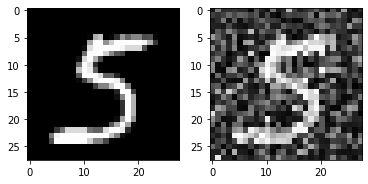

25  :  0.4944780762631317 25
50  :  0.4944780762631317 25
75  :  0.49496115913516775 25
100  :  0.49496115913516775 25
125  :  0.49496115913516775 25
150  :  0.49496115913516775 25
175  :  0.49496115913516775 25
200  :  0.49496115913516775 25
225  :  0.49496115913516775 25
250  :  0.49496115913516775 25
275  :  0.49496115913516775 25
300  :  0.4951111348866311 25
325  :  0.4951111348866311 25
350  :  0.4951111348866311 25
375  :  0.4951111348866311 25
400  :  0.4951111348866311 25
425  :  0.4951111348866311 25
450  :  0.4951111348866311 25
475  :  0.4951111348866311 25
500  :  0.4951111348866311 25
525  :  0.4951138890800213 25
550  :  0.4951138890800213 25
575  :  0.4951966168138496 25
600  :  0.495256967533198 25
625  :  0.4952834943600962 25
650  :  0.49529056026878343 25
675  :  0.4953122289219317 25
700  :  0.4954325881161934 25
725  :  0.49545736688023884 25
750  :  0.49546662095248095 25
775  :  0.4955169715987246 25
800  :  0.4955339894684574 25
Time:  48.06284165382385  second

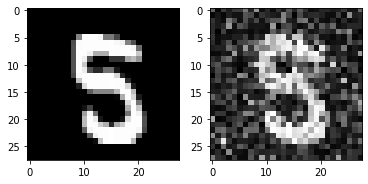

25  :  0.4946697808052534 25
50  :  0.4946697808052534 25
75  :  0.494480583567798 25
100  :  0.494480583567798 25
125  :  0.49468156342826625 25
150  :  0.4946337707563888 25
175  :  0.4946337707563888 25
200  :  0.4946337707563888 25
225  :  0.4946337707563888 25
250  :  0.4946337707563888 25
275  :  0.4946337707563888 25
300  :  0.49479152050641956 25
325  :  0.4949797238068391 25
350  :  0.49508035439121234 25
375  :  0.4950572585255486 25
400  :  0.4950572585255486 25
425  :  0.49522258173782085 25
450  :  0.4954145633280536 25
475  :  0.4954164215713842 25
500  :  0.4954459201283838 25
525  :  0.4954514857607352 25
550  :  0.4954514857607352 25
575  :  0.4954514857607352 25
600  :  0.49548754197061845 25
625  :  0.49551007807747516 25
650  :  0.49551734363094496 25
675  :  0.4955706286571867 25
700  :  0.49557063035315263 25
725  :  0.49557063035315263 25
750  :  0.4956279237008253 25
775  :  0.49563513191212283 25
800  :  0.49563574573740893 25
Time:  49.456347703933716  seconds

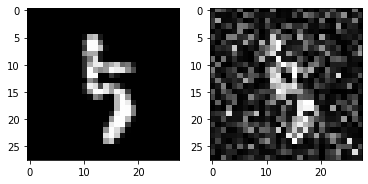

25  :  0.4946591815524446 25
50  :  0.4946591815524446 25
75  :  0.4946541211110709 25
100  :  0.4948357622879683 25
125  :  0.4948357622879683 25
150  :  0.4948357622879683 25
175  :  0.4948900208789874 25
200  :  0.49491833562991605 25
225  :  0.4950671603753135 25
250  :  0.4950821518182019 25
275  :  0.4950821518182019 25
300  :  0.4952451411737982 25
325  :  0.495426505051882 25
350  :  0.49542944412614637 25
375  :  0.49542944412614637 25
400  :  0.4956207543643095 25
425  :  0.49566919034942547 25
450  :  0.495669959416028 25
475  :  0.495669959416028 25
500  :  0.495669959416028 25
525  :  0.4957117111308712 25
550  :  0.4957117111308712 25
575  :  0.4957117111308712 25
600  :  0.4957117111308712 25
625  :  0.4957117111308712 25
650  :  0.4957219744332697 25
675  :  0.49573562107819075 25
700  :  0.49574181705878384 25
725  :  0.49575110252478377 25
750  :  0.4957724455457479 25
775  :  0.4957726222117695 25
800  :  0.49577340801931336 25
Time:  46.1782910823822  seconds
Predic

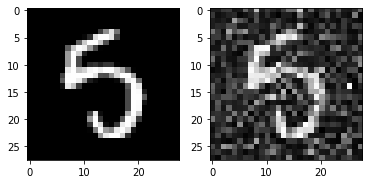

25  :  0.49261792325622844 25
50  :  0.49273077819719824 25
75  :  0.49272899256238667 25
100  :  0.49272899256238667 25
125  :  0.49272899256238667 25
150  :  0.4933063561180309 25
175  :  0.49350179697257207 25
200  :  0.49352636416491374 25
225  :  0.49352636416491374 25
250  :  0.49352636416491374 25
275  :  0.4938952488680517 25
300  :  0.4938952488680517 25
325  :  0.49417931281287675 25
350  :  0.49413300301929636 25
375  :  0.49421311172417687 25
400  :  0.49421311172417687 25
425  :  0.49427784966332516 25
450  :  0.4942550782945312 25
475  :  0.4942550782945312 25
500  :  0.4942550782945312 25
525  :  0.4942550782945312 25
550  :  0.4942550782945312 25
575  :  0.4942550782945312 25
600  :  0.4942550782945312 25
625  :  0.4942550782945312 25
650  :  0.4942550782945312 25
675  :  0.4942550782945312 25
700  :  0.4942550782945312 25
725  :  0.49431167996111225 25
750  :  0.49431167996111225 25
775  :  0.49431167996111225 25
800  :  0.49439140787081043 25
Time:  44.230029821395874

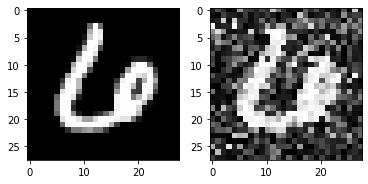

25  :  0.4886965163469855 25
50  :  0.4886965163469855 25
75  :  0.48649449886318163 25
100  :  0.49258496366251975 25
125  :  0.4926703490847262 25
150  :  0.4934548631633401 25
175  :  0.49315965228756287 25
200  :  0.4934078796155607 25
225  :  0.4934078796155607 25
250  :  0.4934078796155607 25
275  :  0.49344251712770565 25
300  :  0.4934078796155607 25
325  :  0.49341013237467285 25
350  :  0.4934873988851424 25
375  :  0.49350298398724113 25
400  :  0.4936278557673387 25
425  :  0.4937936303539012 25
450  :  0.4937936303539012 25
475  :  0.4937936303539012 25
500  :  0.4937936303539012 25
525  :  0.4937936303539012 25
550  :  0.4937936303539012 25
575  :  0.49383715358598945 25
600  :  0.4939729819434183 25
625  :  0.4939729819434183 25
650  :  0.4940383294885515 25
675  :  0.4940383294885515 25
700  :  0.4940383294885515 25
725  :  0.4940833069002815 25
750  :  0.49414163027790975 25
775  :  0.49414163027790975 25
800  :  0.4941499248634793 25
Time:  44.15070462226868  seconds


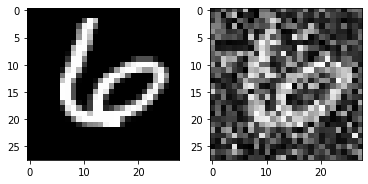

25  :  0.4187252097548524 25
50  :  0.4187252097548524 25
75  :  0.42998837570674203 25
100  :  0.4187252097548524 25
125  :  0.4187252097548524 25
150  :  0.48539211336921073 25
175  :  0.4931881601366874 25
200  :  0.4922271590717938 25
225  :  0.49268676601340405 25
250  :  0.49268676601340405 25
275  :  0.49291652171699146 25
300  :  0.4929131890177387 25
325  :  0.49286540285138314 25
350  :  0.49286540285138314 25
375  :  0.49286540285138314 25
400  :  0.49286540285138314 25
425  :  0.49286540285138314 25
450  :  0.49286540285138314 25
475  :  0.49286540285138314 25
500  :  0.49286540285138314 25
525  :  0.49286540285138314 25
550  :  0.49286540285138314 25
575  :  0.49286540285138314 25
600  :  0.49286540285138314 25
625  :  0.49286540285138314 25
650  :  0.49286540285138314 25
675  :  0.49286540285138314 25
700  :  0.49286540285138314 25
725  :  0.49286540285138314 25
750  :  0.49286540285138314 25
775  :  0.49286540285138314 25
800  :  0.49286540285138314 25
825  :  0.49286540

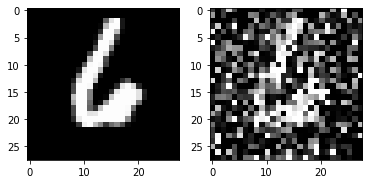

25  :  0.49396990676454006 25
50  :  0.49398398715791697 25
75  :  0.49432330761172943 25
100  :  0.4944493132047124 25
125  :  0.4944493132047124 25
150  :  0.4945046237226974 25
175  :  0.4945046237226974 25
200  :  0.49459046204449436 25
225  :  0.4945954465582425 25
250  :  0.4946306427424987 25
275  :  0.49467801256340993 25
300  :  0.49467801256340993 25
325  :  0.49467801256340993 25
350  :  0.49478966498140753 25
375  :  0.4947490433588539 25
400  :  0.4949218890480384 25
425  :  0.4949218890480384 25
450  :  0.4949617453836238 25
475  :  0.4949652140046117 25
500  :  0.4949652140046117 25
525  :  0.4950119948119218 25
550  :  0.4950119948119218 25
575  :  0.4950731667159655 25
600  :  0.4950731667159655 25
625  :  0.49513388062035263 25
650  :  0.49513388062035263 25
675  :  0.4951427686420059 25
700  :  0.49519849882064126 25
725  :  0.49528482626032266 25
750  :  0.49528482626032266 25
775  :  0.49528482626032266 25
800  :  0.4953122959839317 25
Time:  43.67228603363037  sec

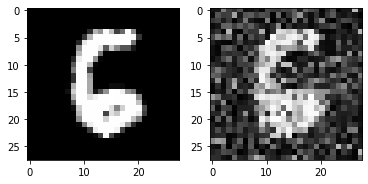

25  :  -0.018939003195402954 25
50  :  0.3810634881844194 25
75  :  0.4855833547545132 25
100  :  0.4922052525690301 25
125  :  0.4926355400496102 25
150  :  0.4926355400496102 25
175  :  0.49266712576381266 25
200  :  0.49266712576381266 25
225  :  0.49266712576381266 25
250  :  0.49266712576381266 25
275  :  0.49266712576381266 25
300  :  0.49290471276059555 25
325  :  0.4929434762152655 25
350  :  0.4929434762152655 25
375  :  0.4929434762152655 25
400  :  0.4929509623067818 25
425  :  0.4929929528476496 25
450  :  0.4931690837106545 25
475  :  0.4931690837106545 25
500  :  0.4932648979463909 25
525  :  0.4934243124822161 25
550  :  0.4934243354229651 25
575  :  0.4934430257276845 25
600  :  0.49349259375156246 25
625  :  0.4935220043783122 25
650  :  0.4936337565090348 25
675  :  0.4936337565090348 25
700  :  0.49364010436608 25
725  :  0.4936449620339545 25
750  :  0.49368024456329 25
775  :  0.49368177075159286 25
800  :  0.4937296409794107 25
825  :  0.4937296410232967 25
850  :

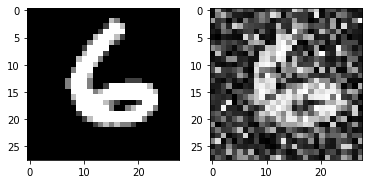

25  :  0.49206520548525945 25
50  :  0.4928834100384036 25
75  :  0.49436523417584116 25
100  :  0.4945983365792525 25
125  :  0.4946611077148291 25
150  :  0.4946611077148291 25
175  :  0.4946611077148291 25
200  :  0.4946611077148291 25
225  :  0.4946611077148291 25
250  :  0.4946680011122832 25
275  :  0.49467726469074147 25
300  :  0.49467726469074147 25
325  :  0.49467726469074147 25
350  :  0.49467726469074147 25
375  :  0.4948005811207431 25
400  :  0.4948005811207431 25
425  :  0.4948005811207431 25
450  :  0.4948005811207431 25
475  :  0.4948005811207431 25
500  :  0.4948005811207431 25
525  :  0.4948005811207431 25
550  :  0.4948005811207431 25
575  :  0.49481269707252157 25
600  :  0.49492022257530627 25
625  :  0.49492544146116546 25
650  :  0.49493011804310605 25
675  :  0.49493011804310605 25
700  :  0.49493011804310605 25
725  :  0.49493011804310605 25
750  :  0.49493011804310605 25
775  :  0.49493011804310605 25
800  :  0.49493011804310605 25
Time:  44.058194160461426  

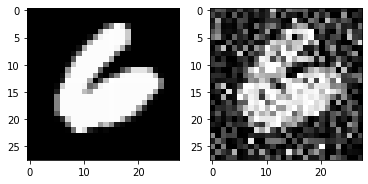

25  :  0.48916164917474636 25
50  :  0.4941285979148864 25
75  :  0.4945025404431745 25
100  :  0.4945025404431745 25
125  :  0.4945025404431745 25
150  :  0.4945025404431745 25
175  :  0.4945025404431745 25
200  :  0.4945025404431745 25
225  :  0.49473202427983015 25
250  :  0.4946614079767614 25
275  :  0.49473602995825844 25
300  :  0.4947173671087383 25
325  :  0.4947173671087383 25
350  :  0.49479765182201707 25
375  :  0.4948439416765367 25
400  :  0.4948439416765367 25
425  :  0.4949783621933964 25
450  :  0.494996675394656 25
475  :  0.4950168467111436 25
500  :  0.49510574747156705 25
525  :  0.49511205927610885 25
550  :  0.49511205927610885 25
575  :  0.49511205927610885 25
600  :  0.49511308420620315 25
625  :  0.4951641937639827 25
650  :  0.49522799893525277 25
675  :  0.49525166736707227 25
700  :  0.4953288274704435 25
725  :  0.4953288043417397 25
750  :  0.49536593406483803 25
775  :  0.4953845147401537 25
800  :  0.49541803866274137 25
Time:  43.875359773635864  seco

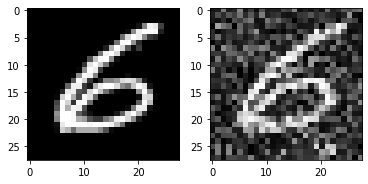

25  :  0.49403496904772964 25
50  :  0.49403496904772964 25
75  :  0.49443355653454646 25
100  :  0.4946611909159037 25
125  :  0.4946611909159037 25
150  :  0.4947907727605312 25
175  :  0.4947907727605312 25
200  :  0.4947907727605312 25
225  :  0.4947907727605312 25
250  :  0.4947907727605312 25
275  :  0.4947949952384764 25
300  :  0.4948061271251831 25
325  :  0.4948061271251831 25
350  :  0.4948283687488058 25
375  :  0.4948283687488058 25
400  :  0.4948283687488058 25
425  :  0.4948283687488058 25
450  :  0.4948283687488058 25
475  :  0.4948543017532716 25
500  :  0.49491338616891767 25
525  :  0.4949056665928819 25
550  :  0.49504213718436674 25
575  :  0.4950448296049555 25
600  :  0.495058420148001 25
625  :  0.49516423579082236 25
650  :  0.49518250192087204 25
675  :  0.4952034022961527 25
700  :  0.4952106161412414 25
725  :  0.49526853391304015 25
750  :  0.49527316002858446 25
775  :  0.4952923630663041 25
800  :  0.4953362547185951 25
Time:  42.068427085876465  seconds


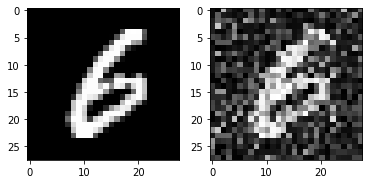

25  :  0.3654854224819863 25
50  :  0.4900738064687484 25
75  :  0.49278604739233123 25
100  :  0.4935758950756249 25
125  :  0.49313453741479424 25
150  :  0.49325449894126455 25
175  :  0.49318320516233194 25
200  :  0.49318320516233194 25
225  :  0.49318320516233194 25
250  :  0.49318320516233194 25
275  :  0.49318320516233194 25
300  :  0.49318320516233194 25
325  :  0.49318320516233194 25
350  :  0.49322211112585573 25
375  :  0.49358230758187177 25
400  :  0.49358230758187177 25
425  :  0.49358230758187177 25
450  :  0.49358230758187177 25
475  :  0.4936951395091801 25
500  :  0.4936951395091801 25
525  :  0.4936951395091801 25
550  :  0.4936951395091801 25
575  :  0.4936951395091801 25
600  :  0.49374791590234335 25
625  :  0.49374791590234335 25
650  :  0.49374791590234335 25
675  :  0.4939687041563202 25
700  :  0.49398072968151463 25
725  :  0.49398072968151463 25
750  :  0.49401977000373415 25
775  :  0.49405160792522534 25
800  :  0.4940916116382014 25
825  :  0.49419575635

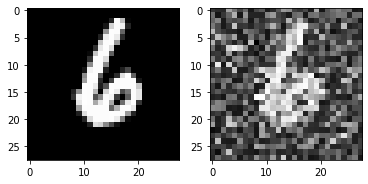

25  :  0.48728589206265105 25
50  :  0.49382557585172654 25
75  :  0.4939963284857086 25
100  :  0.4940358878877102 25
125  :  0.49432721909986377 25
150  :  0.49432721909986377 25
175  :  0.49432721909986377 25
200  :  0.49432721909986377 25
225  :  0.49432721909986377 25
250  :  0.49432721909986377 25
275  :  0.49450985856996704 25
300  :  0.49450985856996704 25
325  :  0.49450985856996704 25
350  :  0.4946666810360999 25
375  :  0.4946666810360999 25
400  :  0.4946666810360999 25
425  :  0.4946666810360999 25
450  :  0.4946666810360999 25
475  :  0.4946666810360999 25
500  :  0.4946666810360999 25
525  :  0.4946666810360999 25
550  :  0.4947823071181296 25
575  :  0.4947775418810408 25
600  :  0.4947775418810408 25
625  :  0.4947775418810408 25
650  :  0.4947775418810408 25
675  :  0.49480928820038955 25
700  :  0.4948099098873209 25
725  :  0.49484537656406435 25
750  :  0.4948742290124071 25
775  :  0.4949404688936747 25
800  :  0.4949696458671299 25
Time:  42.711498975753784  sec

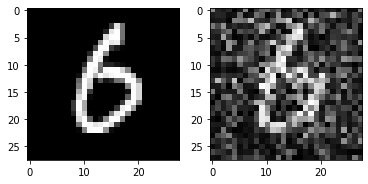

25  :  0.4864512029793677 25
50  :  0.4864512029793677 25
75  :  0.49333437468485625 25
100  :  0.49353799033242207 25
125  :  0.49336245229156533 25
150  :  0.4937700593328427 25
175  :  0.4937700593328427 25
200  :  0.4937700593328427 25
225  :  0.4937700593328427 25
250  :  0.4937700593328427 25
275  :  0.4937700593328427 25
300  :  0.49379160756072304 25
325  :  0.4938646500841851 25
350  :  0.49387296762064903 25
375  :  0.49396848827573975 25
400  :  0.4939832436774831 25
425  :  0.4940891268057736 25
450  :  0.49411199057645677 25
475  :  0.49419526757944465 25
500  :  0.49419957712756796 25
525  :  0.49419957712756796 25
550  :  0.49428463446821447 25
575  :  0.4942917351220441 25
600  :  0.49436542168928416 25
625  :  0.49436538365582305 25
650  :  0.4944246242243143 25
675  :  0.4944246369532155 25
700  :  0.4944246369532155 25
725  :  0.49443622619416605 25
750  :  0.4944363165579624 25
775  :  0.49447095619483294 25
800  :  0.49447095619483294 25
Time:  41.49569892883301  s

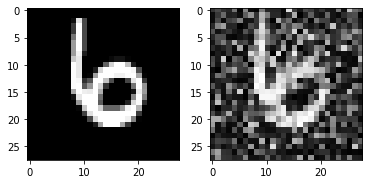

25  :  0.4944207605607509 25
50  :  0.4944207605607509 25
75  :  0.4944207605607509 25
100  :  0.49473699135237936 25
125  :  0.4948119453962583 25
150  :  0.4948119453962583 25
175  :  0.4948119453962583 25
200  :  0.4948119453962583 25
225  :  0.4948119453962583 25
250  :  0.4948119453962583 25
275  :  0.4948119453962583 25
300  :  0.4948119453962583 25
325  :  0.4948119453962583 25
350  :  0.4948119453962583 25
375  :  0.4948119453962583 25
400  :  0.4948119453962583 25
425  :  0.4950225580825237 25
450  :  0.49501492412099973 25
475  :  0.49501492412099973 25
500  :  0.49502574903277613 25
525  :  0.49502462787399526 25
550  :  0.49502462787399526 25
575  :  0.49502462787399526 25
600  :  0.49502462787399526 25
625  :  0.49502462787399526 25
650  :  0.49502462787399526 25
675  :  0.49502462787399526 25
700  :  0.49502462787399526 25
725  :  0.49502462787399526 25
750  :  0.49502462787399526 25
775  :  0.4950778389393837 25
800  :  0.49508487185369754 25
Time:  43.568336725234985  s

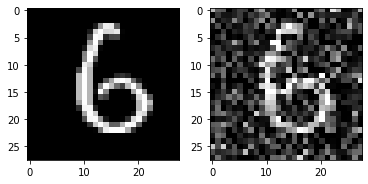

25  :  0.49411570313116393 25
50  :  0.49411570313116393 25
75  :  0.49411570313116393 25
100  :  0.49411570313116393 25
125  :  0.49411570313116393 25
150  :  0.49418992160213027 25
175  :  0.4941424093596075 25
200  :  0.4941424093596075 25
225  :  0.4941785834684208 25
250  :  0.4946496781486201 25
275  :  0.4942440967418428 25
300  :  0.4943318808181947 25
325  :  0.49442068499708147 25
350  :  0.4945214344498431 25
375  :  0.4949425467276928 25
400  :  0.4949425467276928 25
425  :  0.4949425467276928 25
450  :  0.4949425467276928 25
475  :  0.4949425467276928 25
500  :  0.494945513077129 25
525  :  0.49495250366348964 25
550  :  0.49500928607146844 25
575  :  0.495023679522578 25
600  :  0.49509307156235416 25
625  :  0.4950944753966903 25
650  :  0.4951272706573222 25
675  :  0.4951287391549903 25
700  :  0.49516170003245036 25
725  :  0.4952163697919948 25
750  :  0.49521627438944665 25
775  :  0.49521627438944665 25
800  :  0.49523437608201104 25
Time:  44.39861845970154  secon

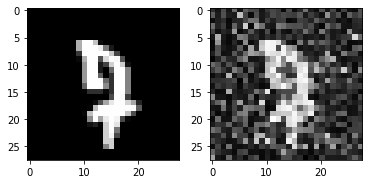

25  :  0.49497603047986244 25
50  :  0.49500279438367983 25
75  :  0.4952113391770478 25
100  :  0.4951075603020811 25
125  :  0.4951075603020811 25
150  :  0.4951075603020811 25
175  :  0.49535720574075515 25
200  :  0.4952875271458918 25
225  :  0.49524217266770243 25
250  :  0.49524217266770243 25
275  :  0.49540750968611447 25
300  :  0.49540750968611447 25
325  :  0.49540750968611447 25
350  :  0.49556483325979483 25
375  :  0.49556483325979483 25
400  :  0.49556483325979483 25
425  :  0.49556483325979483 25
450  :  0.49556483325979483 25
475  :  0.49556483325979483 25
500  :  0.49571620216709517 25
525  :  0.4957458602060129 25
550  :  0.49579083798186435 25
575  :  0.4957965345033676 25
600  :  0.4957965345033676 25
625  :  0.4958095932241537 25
650  :  0.49585595535432025 25
675  :  0.4958443805819085 25
700  :  0.4958716619081958 25
725  :  0.4959438008548324 25
750  :  0.49594570437064095 25
775  :  0.49594979422299257 25
800  :  0.49597794218820024 25
Time:  45.2873842716217

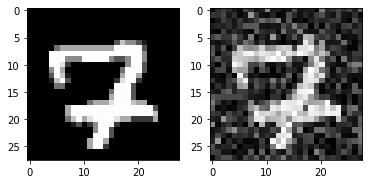

25  :  0.49261471189609496 25
50  :  0.49261471189609496 25
75  :  0.49356459672704506 25
100  :  0.49335636353563056 25
125  :  0.49335636353563056 25
150  :  0.49335636353563056 25
175  :  0.49335636353563056 25
200  :  0.4934522448142212 25
225  :  0.49348621527583325 25
250  :  0.49348621527583325 25
275  :  0.4936354325962224 25
300  :  0.4939195858681193 25
325  :  0.49390843497603754 25
350  :  0.4942318499410437 25
375  :  0.4943285851156481 25
400  :  0.4943285851156481 25
425  :  0.4943285851156481 25
450  :  0.4943285851156481 25
475  :  0.4943756788367691 25
500  :  0.4944173750543514 25
525  :  0.4946134833131281 25
550  :  0.4946134833131281 25
575  :  0.4946220523714534 25
600  :  0.4946227032280579 25
625  :  0.4946718814563409 25
650  :  0.49467270001568914 25
675  :  0.49467270001568914 25
700  :  0.4946770060400492 25
725  :  0.49470436608667 25
750  :  0.4947281058843556 25
775  :  0.49473156067351876 25
800  :  0.49473434946052586 25
Time:  44.432931661605835  seco

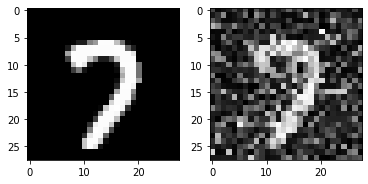

25  :  0.12648303971831446 25
50  :  0.4820350579649175 25
75  :  0.49380544003976046 25
100  :  0.49274600018281933 25
125  :  0.49321289212010866 25
150  :  0.4930062786629077 25
175  :  0.49336824895804654 25
200  :  0.49336824895804654 25
225  :  0.49336824895804654 25
250  :  0.49336824895804654 25
275  :  0.49336824895804654 25
300  :  0.49336824895804654 25
325  :  0.49336824895804654 25
350  :  0.49336824895804654 25
375  :  0.4934441101890977 25
400  :  0.49346398161466143 25
425  :  0.49350513075303426 25
450  :  0.493510007239257 25
475  :  0.49357236688221806 25
500  :  0.4935474825494254 25
525  :  0.4936086254658799 25
550  :  0.493659641966444 25
575  :  0.49378981713485826 25
600  :  0.49393235256312656 25
625  :  0.49393235256312656 25
650  :  0.49393235256312656 25
675  :  0.4939760947946512 25
700  :  0.4939770308515019 25
725  :  0.4940469445905293 25
750  :  0.4940552389981242 25
775  :  0.4940692861735237 25
800  :  0.4941393779747918 25
825  :  0.4941393779747918

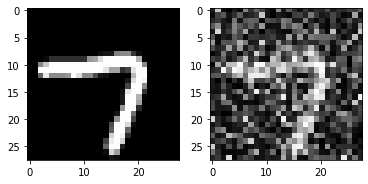

25  :  0.22704870517029516 25
50  :  0.4927868695371054 25
75  :  0.4934645679254794 25
100  :  0.4937580906610675 25
125  :  0.4937580906610675 25
150  :  0.4937580906610675 25
175  :  0.4937580906610675 25
200  :  0.4937580906610675 25
225  :  0.4937580906610675 25
250  :  0.4937580906610675 25
275  :  0.4937580906610675 25
300  :  0.4937580906610675 25
325  :  0.49379297236817515 25
350  :  0.49379297236817515 25
375  :  0.4940106577390637 25
400  :  0.4940263953663903 25
425  :  0.4941668095480718 25
450  :  0.4941668095480718 25
475  :  0.4941668095480718 25
500  :  0.4941668095480718 25
525  :  0.4941668095480718 25
550  :  0.4941668095480718 25
575  :  0.49419945980997343 25
600  :  0.49420303273121674 25
625  :  0.49420303273121674 25
650  :  0.49420768970338214 25
675  :  0.4941851823511402 25
700  :  0.4941851823511402 25
725  :  0.4941851823511402 25
750  :  0.4942284635675587 25
775  :  0.4942506086144 25
800  :  0.4942724471868975 25
825  :  0.49432047367421933 25
Time:  4

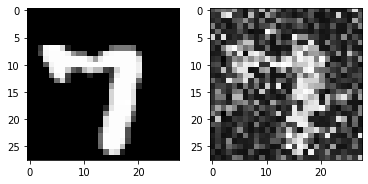

25  :  0.49507584124005904 25
50  :  0.49507584124005904 25
75  :  0.495164661660264 25
100  :  0.49521401733854303 25
125  :  0.49521401733854303 25
150  :  0.49521401733854303 25
175  :  0.49521401733854303 25
200  :  0.49521401733854303 25
225  :  0.49521401733854303 25
250  :  0.4955197905342497 25
275  :  0.49552819008126847 25
300  :  0.495764162732634 25
325  :  0.4958977234848741 25
350  :  0.4959400228762116 25
375  :  0.4959479259237291 25
400  :  0.4960462419435233 25
425  :  0.4961231221486279 25
450  :  0.4961231221486279 25
475  :  0.4961231221486279 25
500  :  0.4961231221486279 25
525  :  0.4961231221486279 25
550  :  0.4961240401727704 25
575  :  0.4961482782991449 25
600  :  0.4961482782991449 25
625  :  0.49615000365356327 25
650  :  0.49619127902854565 25
675  :  0.4961968726313425 25
700  :  0.49620107624658344 25
725  :  0.4962129420853102 25
750  :  0.49622035090949074 25
775  :  0.49622035090949074 25
800  :  0.49622051198888345 25
Time:  44.85644245147705  seco

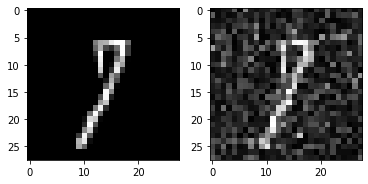

25  :  0.4941696997332492 25
50  :  0.4941696997332492 25
75  :  0.4941696997332492 25
100  :  0.4941696997332492 25
125  :  0.4941696997332492 25
150  :  0.4941696997332492 25
175  :  0.4941696997332492 25
200  :  0.4941696997332492 25
225  :  0.4941696997332492 25
250  :  0.49481035071050666 25
275  :  0.49481035071050666 25
300  :  0.49481035071050666 25
325  :  0.49481035071050666 25
350  :  0.49481035071050666 25
375  :  0.49481035071050666 25
400  :  0.49481035071050666 25
425  :  0.49481035071050666 25
450  :  0.49490463575480376 25
475  :  0.49490463644084015 25
500  :  0.49494152401413644 25
525  :  0.4949348757334301 25
550  :  0.495113145130655 25
575  :  0.495113145130655 25
600  :  0.495113145130655 25
625  :  0.495113145130655 25
650  :  0.49523955423493016 25
675  :  0.49523782656095044 25
700  :  0.49523782656095044 25
725  :  0.4952460886160187 25
750  :  0.4952721562901644 25
775  :  0.49528932830256905 25
800  :  0.49528932830256905 25
Time:  51.63589859008789  secon

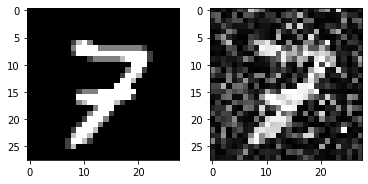

25  :  0.4713925366424911 25
50  :  0.4927713048992925 25
75  :  0.4929744481296816 25
100  :  0.49281733264348676 25
125  :  0.493204061821814 25
150  :  0.4936226695164451 25
175  :  0.4936226695164451 25
200  :  0.4936226695164451 25
225  :  0.4936226695164451 25
250  :  0.4936226695164451 25
275  :  0.4936226695164451 25
300  :  0.4936226695164451 25
325  :  0.4937235056453279 25
350  :  0.4937392570561267 25
375  :  0.4937392570561267 25
400  :  0.4937392570561267 25
425  :  0.4937392570561267 25
450  :  0.4937392570561267 25
475  :  0.49381180610926295 25
500  :  0.49386363810847556 25
525  :  0.49392728078412956 25
550  :  0.4939323043154938 25
575  :  0.493954541278076 25
600  :  0.493954541278076 25
625  :  0.49407503416317217 25
650  :  0.49408056622832447 25
675  :  0.4941855409600359 25
700  :  0.494186314941784 25
725  :  0.49424206613287136 25
750  :  0.4942402697557289 25
775  :  0.4942446153569583 25
800  :  0.4942446153569583 25
825  :  0.4942446153569583 25
Time:  48.

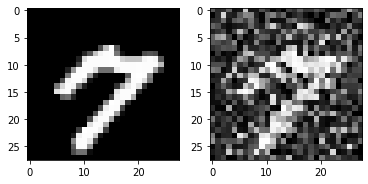

25  :  0.49216750902256146 25
50  :  0.4941349977036717 25
75  :  0.4939471829266652 25
100  :  0.4932302600777208 25
125  :  0.49380429759091626 25
150  :  0.49380429759091626 25
175  :  0.4939704688401343 25
200  :  0.4939704688401343 25
225  :  0.4939704688401343 25
250  :  0.4939704688401343 25
275  :  0.4939704688401343 25
300  :  0.4939704688401343 25
325  :  0.4942747089131948 25
350  :  0.49428461040213056 25
375  :  0.49428461040213056 25
400  :  0.49428461040213056 25
425  :  0.49428461040213056 25
450  :  0.4943454144497203 25
475  :  0.4943454144497203 25
500  :  0.4944160326819518 25
525  :  0.49449042261903386 25
550  :  0.49450745380848327 25
575  :  0.49452559582439065 25
600  :  0.49452559582439065 25
625  :  0.49462014954366673 25
650  :  0.49464001945008274 25
675  :  0.49471573554044984 25
700  :  0.4947808406291994 25
725  :  0.4947808406291994 25
750  :  0.49479010799457745 25
775  :  0.4947945820633192 25
800  :  0.49481222293154775 25
Time:  47.05580973625183  s

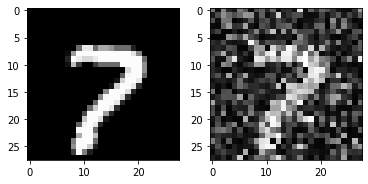

25  :  0.4870397349725222 25
50  :  0.49435914928740055 25
75  :  0.49466696562294243 25
100  :  0.49466696562294243 25
125  :  0.49466696562294243 25
150  :  0.49466696562294243 25
175  :  0.49466696562294243 25
200  :  0.49466696562294243 25
225  :  0.49466696562294243 25
250  :  0.49466696562294243 25
275  :  0.4947654375677918 25
300  :  0.4947654375677918 25
325  :  0.4947654375677918 25
350  :  0.4947654375677918 25
375  :  0.4947654375677918 25
400  :  0.4947690696986244 25
425  :  0.4947949159512196 25
450  :  0.4947949159512196 25
475  :  0.4947949159512196 25
500  :  0.4947949159512196 25
525  :  0.4947949159512196 25
550  :  0.49484507320875165 25
575  :  0.4948306038203982 25
600  :  0.49484178837177184 25
625  :  0.49488854972464374 25
650  :  0.4949213747208101 25
675  :  0.49493988625977847 25
700  :  0.49495100415445437 25
725  :  0.49495201279130985 25
750  :  0.4949739815078845 25
775  :  0.4950179597777424 25
800  :  0.4950226441371115 25
Time:  46.59773135185242  se

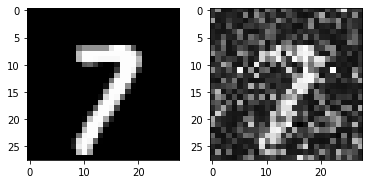

25  :  0.4909569023961085 25
50  :  0.4928576609428184 25
75  :  0.4933225628406641 25
100  :  0.4933225628406641 25
125  :  0.4933225628406641 25
150  :  0.49345748781047066 25
175  :  0.49345748781047066 25
200  :  0.49366607763010484 25
225  :  0.4936475652992179 25
250  :  0.49411025143132475 25
275  :  0.49411025143132475 25
300  :  0.49411025143132475 25
325  :  0.49411025143132475 25
350  :  0.49414165488794876 25
375  :  0.49420680861005895 25
400  :  0.4942003710751267 25
425  :  0.49421206966133796 25
450  :  0.49427796944936847 25
475  :  0.49425836003445 25
500  :  0.4943424252174231 25
525  :  0.49437070567062164 25
550  :  0.49439589683386875 25
575  :  0.4944206347014845 25
600  :  0.4944403925151893 25
625  :  0.4944464248971992 25
650  :  0.494458545292097 25
675  :  0.49446731109844866 25
700  :  0.4944754856885811 25
725  :  0.49447872780019225 25
750  :  0.49447872780019225 25
775  :  0.4944871176123427 25
800  :  0.4944989259986253 25
Time:  49.01243615150452  seco

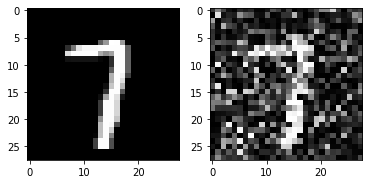

25  :  0.49424843489866793 25
50  :  0.49424843489866793 25
75  :  0.49447224224940184 25
100  :  0.49447224224940184 25
125  :  0.49447224224940184 25
150  :  0.49447224224940184 25
175  :  0.49447224224940184 25
200  :  0.49447224224940184 25
225  :  0.4945520251309585 25
250  :  0.4945471307849332 25
275  :  0.4946453532829103 25
300  :  0.4948113934400189 25
325  :  0.4948113934400189 25
350  :  0.49482090514487004 25
375  :  0.49482090514487004 25
400  :  0.49482090514487004 25
425  :  0.49482090514487004 25
450  :  0.49482090514487004 25
475  :  0.49482090514487004 25
500  :  0.49482090514487004 25
525  :  0.49482090514487004 25
550  :  0.49482090514487004 25
575  :  0.49482090514487004 25
600  :  0.49487283572934027 25
625  :  0.49487295517167484 25
650  :  0.49487295517167484 25
675  :  0.49487295517167484 25
700  :  0.49487513905226815 25
725  :  0.49487513905226815 25
750  :  0.4949326153834281 25
775  :  0.4949326153834281 25
800  :  0.49496155009752196 25
Time:  49.19027304

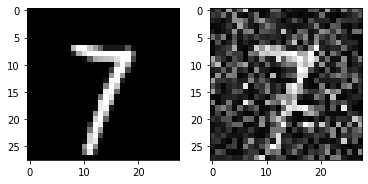

25  :  0.49164852448126284 25
50  :  0.49164852448126284 25
75  :  0.4930128231975439 25
100  :  0.4940121322412171 25
125  :  0.4938516953358876 25
150  :  0.4937240708273341 25
175  :  0.4937240708273341 25
200  :  0.4939822785026843 25
225  :  0.4937240708273341 25
250  :  0.4937240708273341 25
275  :  0.4937240708273341 25
300  :  0.4937240708273341 25
325  :  0.49416426825550785 25
350  :  0.49419576093274414 25
375  :  0.49430948506145445 25
400  :  0.49433019994442823 25
425  :  0.4944762286033505 25
450  :  0.4944762286033505 25
475  :  0.4944762286033505 25
500  :  0.4944762286033505 25
525  :  0.4944762286033505 25
550  :  0.4945074614886514 25
575  :  0.4945074614886514 25
600  :  0.4945074614886514 25
625  :  0.4945183552426982 25
650  :  0.4945374078076467 25
675  :  0.4945472378493679 25
700  :  0.4945379889913769 25
725  :  0.4945379889913769 25
750  :  0.4945379889913769 25
775  :  0.49455315092088414 25
800  :  0.4946007344892503 25
Time:  50.20795655250549  seconds
Pr

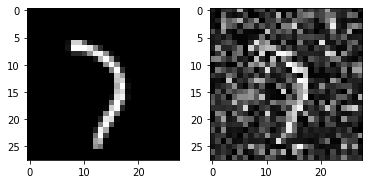

25  :  -0.5036841320528536 25
50  :  -0.5036841320528536 25
75  :  -0.37251080004564563 25
100  :  -0.45984958661465675 25
125  :  0.22250358938320003 25
150  :  -0.2538383364368429 25
175  :  -0.2538383364368429 25
200  :  0.06431141526445762 25
225  :  0.4801487340844725 25
250  :  0.47896079108592093 25
275  :  0.48916469241875826 25
300  :  0.4920175155618754 25
325  :  0.49071485835455736 25
350  :  0.4911784184422831 25
375  :  0.4915986918603126 25
400  :  0.4921361599527257 25
425  :  0.4921879836407663 25
450  :  0.4925100098027704 25
475  :  0.4925100098027704 25
500  :  0.4925345573946773 25
525  :  0.4927244417696605 25
550  :  0.49280716604676106 25
575  :  0.49280716604676106 25
600  :  0.4928470246444211 25
625  :  0.4928877583715465 25
650  :  0.49297434383207467 25
675  :  0.49313422698217346 25
700  :  0.4931403544508161 25
725  :  0.4931935605688173 25
750  :  0.4931975668055409 25
775  :  0.49321291382658966 25
800  :  0.49322597348205877 25
825  :  0.49324749092625

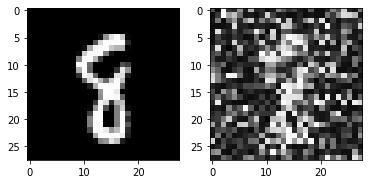

25  :  -0.4800728699077585 25
50  :  -0.4548913755045799 25
75  :  -0.4501497494018338 25
100  :  0.47634406920863065 25
125  :  0.1369013270789564 25
150  :  0.15085534852438556 25
175  :  0.4367605532532184 25
200  :  0.4894950498720552 25
225  :  0.491292853082112 25
250  :  0.49263160155154384 25
275  :  0.49263160155154384 25
300  :  0.49263160155154384 25
325  :  0.4929626941950767 25
350  :  0.4929626941950767 25
375  :  0.4929626941950767 25
400  :  0.49296284285809117 25
425  :  0.49316435452544705 25
450  :  0.4932043437006295 25
475  :  0.49371019495265606 25
500  :  0.4937801459754068 25
525  :  0.4937801459754068 25
550  :  0.4937801459754068 25
575  :  0.49387742299147785 25
600  :  0.49389504337223417 25
625  :  0.49389504337223417 25
650  :  0.4939282017830031 25
675  :  0.4939526052036678 25
700  :  0.4939695821006304 25
725  :  0.49398923715520165 25
750  :  0.4939954184382221 25
775  :  0.4940439492132571 25
800  :  0.49407105434026233 25
825  :  0.494069134541343 25

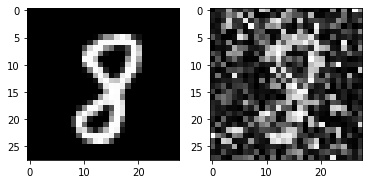

25  :  -0.5045274400852415 25
50  :  -0.5043887524972682 25
75  :  -0.5038736470825352 25
100  :  -0.503276807149539 25
125  :  -0.503276807149539 25
150  :  -0.503276807149539 25
175  :  -0.503276807149539 25
200  :  -0.503276807149539 25
225  :  -0.503276807149539 25
250  :  -0.5032158969740602 25
275  :  -0.5031980114865718 25
300  :  -0.5031606266770211 25
325  :  -0.5031600689578045 25
350  :  -0.5031172241895874 25
375  :  -0.5031095787237408 25
400  :  -0.5030792104268932 25
425  :  -0.5030788542869069 25
450  :  -0.503064735761741 25
475  :  -0.503064735761741 25
500  :  -0.5030507436658377 25
525  :  -0.5030507436658377 25
550  :  -0.503043999973727 25
575  :  -0.503043999973727 25
600  :  -0.5030377228306759 25
625  :  -0.5030323611790728 25
650  :  -0.5030301414674916 25
675  :  -0.5030198816415821 25
700  :  -0.5030079389740818 25
725  :  -0.5030079389740818 25
750  :  -0.5030021388081679 25
775  :  -0.5029977191570034 25
800  :  -0.5029859055778438 25
Time:  51.61944985389

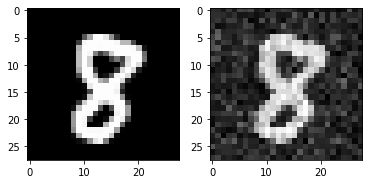

25  :  -0.5042867905213886 25
50  :  -0.5042553895092088 25
75  :  -0.5041758962885211 25
100  :  -0.504160321205495 25
125  :  -0.5038697153015604 25
150  :  -0.5038697153015604 25
175  :  -0.5038430681416296 25
200  :  -0.5036196526413185 25
225  :  -0.5036017186908749 25
250  :  -0.5036016751154643 25
275  :  -0.503537935300994 25
300  :  -0.5035053652408517 25
325  :  -0.5034783331974421 25
350  :  -0.5034777166108351 25
375  :  -0.5034549570568226 25
400  :  -0.5034494128391549 25
425  :  -0.5034327487159685 25
450  :  -0.5033996195616458 25
475  :  -0.5033519276753112 25
500  :  -0.5033110019785022 25
525  :  -0.5032975136553964 25
550  :  -0.5032859626733064 25
575  :  -0.5032692743033742 25
600  :  -0.5032692743033742 25
625  :  -0.5032692743033742 25
650  :  -0.5032692743033742 25
675  :  -0.5032692743033742 25
700  :  -0.5032637037907479 25
725  :  -0.5032533178807593 25
750  :  -0.5032287120964789 25
775  :  -0.5032287120964789 25
800  :  -0.503219129965649 25
Time:  48.0053

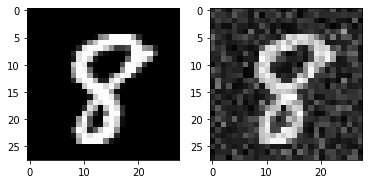

25  :  -0.31908861139064937 25
50  :  -0.31908861139064937 25
75  :  -0.20309787727567452 25
100  :  -0.20309787727567452 25
125  :  0.48178250118262034 25
150  :  0.25576684037195957 25
175  :  0.25576684037195957 25
200  :  0.477036764482481 25
225  :  0.4853246320556818 25
250  :  0.4889987461999442 25
275  :  0.4861048240555822 25
300  :  0.48492562415043317 25
325  :  0.4907461661677731 25
350  :  0.49007787074327686 25
375  :  0.48933986314213623 25
400  :  0.4902164764168122 25
425  :  0.4902889108814788 25
450  :  0.4909225473022468 25
475  :  0.4913523794425898 25
500  :  0.4919312932154417 25
525  :  0.49201612808450124 25
550  :  0.4921413000401905 25
575  :  0.4921688776641584 25
600  :  0.49220775225724883 25
625  :  0.49220775225724883 25
650  :  0.49220775225724883 25
675  :  0.4922990417698723 25
700  :  0.4923259601713158 25
725  :  0.4923417968349493 25
750  :  0.4923417968349493 25
775  :  0.49236227478873285 25
800  :  0.4924982871598132 25
825  :  0.492508056947899

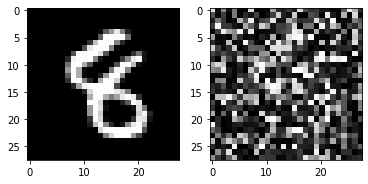

25  :  -0.5045965949224973 25
50  :  -0.5043706330607359 25
75  :  -0.5041785039052111 25
100  :  -0.5039762434818652 25
125  :  -0.5036470403055658 25
150  :  -0.5036470403055658 25
175  :  -0.5036470403055658 25
200  :  -0.5036470403055658 25
225  :  -0.5034356132079248 25
250  :  -0.5034070940614392 25
275  :  -0.5034070940614392 25
300  :  -0.5034070940614392 25
325  :  -0.5034070940614392 25
350  :  -0.5033726500310564 25
375  :  -0.5033709442384037 25
400  :  -0.5033436036528697 25
425  :  -0.503342404497879 25
450  :  -0.5032327998110375 25
475  :  -0.5032327998110375 25
500  :  -0.5032100749184588 25
525  :  -0.5031833912481098 25
550  :  -0.5031629320928663 25
575  :  -0.5031629320928663 25
600  :  -0.5031332703145021 25
625  :  -0.5031332703145021 25
650  :  -0.5031332703145021 25
675  :  -0.5031332703145021 25
700  :  -0.5031332703145021 25
725  :  -0.5031320844254453 25
750  :  -0.5031320844254453 25
775  :  -0.5031320844254453 25
800  :  -0.5031320844254453 25
Time:  58.45

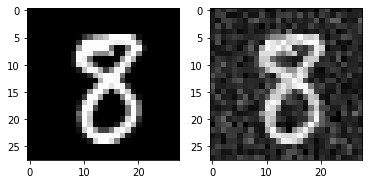

25  :  -0.5043881372746688 25
50  :  -0.5043406601620188 25
75  :  -0.5040529265003922 25
100  :  -0.503873935986831 25
125  :  -0.5037477175801154 25
150  :  -0.5036103204290191 25
175  :  -0.5035864370428722 25
200  :  -0.5035864323572287 25
225  :  -0.5035864323572287 25
250  :  -0.5034934040119166 25
275  :  -0.5034850747838436 25
300  :  -0.5034827007532173 25
325  :  -0.5034533606235203 25
350  :  -0.503436992297003 25
375  :  -0.5033698701790248 25
400  :  -0.5033698701790248 25
425  :  -0.5033696395165207 25
450  :  -0.5033032610812231 25
475  :  -0.5032967611532821 25
500  :  -0.5032678407014711 25
525  :  -0.5032678407014711 25
550  :  -0.5032642341930759 25
575  :  -0.5032460660529365 25
600  :  -0.5032203593653342 25
625  :  -0.5032113600989658 25
650  :  -0.5032109953088019 25
675  :  -0.5032098913262522 25
700  :  -0.5031954821027845 25
725  :  -0.5031883538167801 25
750  :  -0.5031758034845841 25
775  :  -0.5031758034845841 25
800  :  -0.5031679411249351 25
Time:  51.059

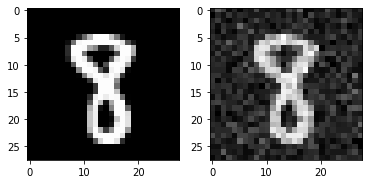

25  :  0.40060389414776754 25
50  :  0.4818146880913418 25
75  :  0.49312547312941124 25
100  :  0.46608491182018236 25
125  :  0.46608491182018236 25
150  :  0.4931357141589574 25
175  :  0.49363236862835524 25
200  :  0.49424573977650693 25
225  :  0.49438462759072577 25
250  :  0.49438462759072577 25
275  :  0.49438462759072577 25
300  :  0.49438462759072577 25
325  :  0.49438462759072577 25
350  :  0.49438462759072577 25
375  :  0.49438462759072577 25
400  :  0.49438462759072577 25
425  :  0.49438462759072577 25
450  :  0.49438462759072577 25
475  :  0.49438462759072577 25
500  :  0.49453355651238673 25
525  :  0.49456990476448875 25
550  :  0.49456990476448875 25
575  :  0.49456990476448875 25
600  :  0.49456990476448875 25
625  :  0.49458656734603557 25
650  :  0.4947420356674578 25
675  :  0.49473751197237115 25
700  :  0.49473751197237115 25
725  :  0.49479037218685556 25
750  :  0.4948680755919347 25
775  :  0.4948680755919347 25
800  :  0.49491543157818974 25
825  :  0.494922

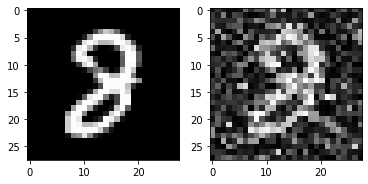

25  :  -0.5042799739345992 25
50  :  -0.5042799739345992 25
75  :  -0.5032401608955749 25
100  :  -0.4699534650190843 25
125  :  -0.30696030559351845 25
150  :  -0.2838316509276358 25
175  :  0.4894052425138334 25
200  :  0.4914529338466434 25
225  :  0.4911192806367585 25
250  :  0.49080169318794636 25
275  :  0.49016117225692246 25
300  :  0.4908838972510632 25
325  :  0.4922523822681382 25
350  :  0.491612900638049 25
375  :  0.49223146093890136 25
400  :  0.49223146093890136 25
425  :  0.49223146093890136 25
450  :  0.4923503456112321 25
475  :  0.49277344502746584 25
500  :  0.49277633099152957 25
525  :  0.4929782291507786 25
550  :  0.49312297416136486 25
575  :  0.49312133617603116 25
600  :  0.49312133617603116 25
625  :  0.49312133617603116 25
650  :  0.4931280471690545 25
675  :  0.49313587000932113 25
700  :  0.4931520398439253 25
725  :  0.4931563192545634 25
750  :  0.4931680255859821 25
775  :  0.49316802560574297 25
800  :  0.49318678332993887 25
825  :  0.4931907017929

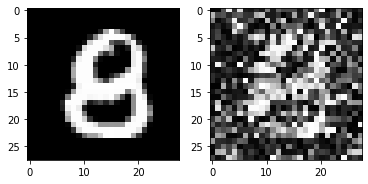

25  :  -0.5043574021154773 25
50  :  -0.5042971588979074 25
75  :  -0.504151352268874 25
100  :  -0.5041076869782473 25
125  :  -0.5041076869782473 25
150  :  -0.5039986441700481 25
175  :  -0.5038728456426351 25
200  :  -0.5037852474744955 25
225  :  -0.5036822797549048 25
250  :  -0.5035690056288189 25
275  :  -0.5035159144472036 25
300  :  -0.5035159144472036 25
325  :  -0.5035159144472036 25
350  :  -0.5034892176684912 25
375  :  -0.5034590867297639 25
400  :  -0.5034171246759828 25
425  :  -0.5034171084755997 25
450  :  -0.5034112934924776 25
475  :  -0.5033883852879595 25
500  :  -0.5033750210494162 25
525  :  -0.5033750210494162 25
550  :  -0.503362251689753 25
575  :  -0.5032992741925478 25
600  :  -0.5032834059753098 25
625  :  -0.5032806751232538 25
650  :  -0.5032547561215278 25
675  :  -0.5032547561215278 25
700  :  -0.5032547561215278 25
725  :  -0.5032407087618465 25
750  :  -0.5032277916802815 25
775  :  -0.5032234955326076 25
800  :  -0.5032185101162396 25
Time:  52.309

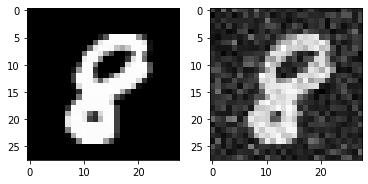

25  :  -0.5023534318070384 25
50  :  -0.5019399765872862 25
75  :  -0.5023534318070384 25
100  :  -0.48174025582367047 25
125  :  -0.17905033935092463 25
150  :  -0.4630456119803848 25
175  :  0.17831879423576752 25
200  :  0.47352090947079745 25
225  :  0.4855395871114175 25
250  :  0.368693281544428 25
275  :  0.4914702199815859 25
300  :  0.48084689334030223 25
325  :  0.4862945695471016 25
350  :  0.49249815801213603 25
375  :  0.49171699141495134 25
400  :  0.49171699141495134 25
425  :  0.49171699141495134 25
450  :  0.4921823831096631 25
475  :  0.4921823831096631 25
500  :  0.4921823831096631 25
525  :  0.4921823831096631 25
550  :  0.4923090807805302 25
575  :  0.4923090807805302 25
600  :  0.49260103926452753 25
625  :  0.4926612343875293 25
650  :  0.4926612343875293 25
675  :  0.49294240739110734 25
700  :  0.49294240739110734 25
725  :  0.49305529256807956 25
750  :  0.4930903354850171 25
775  :  0.4930903354850171 25
800  :  0.49318116738262485 25
825  :  0.49318113795217

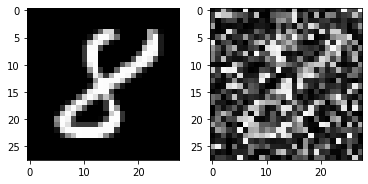

25  :  -0.5030115332087304 25
50  :  -0.49931390101728024 25
75  :  -0.33850005512407644 25
100  :  -0.5030958340197107 25
125  :  -0.5020955627900131 25
150  :  -0.3563184650954488 25
175  :  0.36985261439007094 25
200  :  0.4721537094351858 25
225  :  0.49104729500779354 25
250  :  0.48874467957893036 25
275  :  0.4915020891851809 25
300  :  0.4915020891851809 25
325  :  0.4916636173347702 25
350  :  0.49202322608543414 25
375  :  0.49207676907144215 25
400  :  0.49226370311764717 25
425  :  0.4923926831690629 25
450  :  0.4923926831690629 25
475  :  0.4923926831690629 25
500  :  0.4923926831690629 25
525  :  0.4923926831690629 25
550  :  0.4923926831690629 25
575  :  0.4923926831690629 25
600  :  0.4923926831690629 25
625  :  0.4925713564302035 25
650  :  0.49258422859863815 25
675  :  0.49258422859863815 25
700  :  0.4926234645387291 25
725  :  0.4926567051706434 25
750  :  0.4926886867534982 25
775  :  0.4927643538676711 25
800  :  0.4927643538676711 25
825  :  0.4927923219569978 

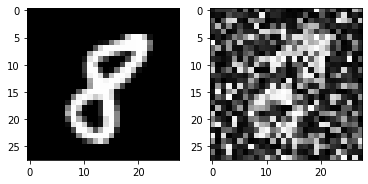

25  :  0.4932413081280309 25
50  :  0.49397655172853794 25
75  :  0.4938411445082161 25
100  :  0.49420866199182 25
125  :  0.49420866199182 25
150  :  0.49420866199182 25
175  :  0.49420866199182 25
200  :  0.49420866199182 25
225  :  0.49420866199182 25
250  :  0.4942575585629623 25
275  :  0.49422890447217216 25
300  :  0.4944360180494194 25
325  :  0.49446537219848896 25
350  :  0.49446537219848896 25
375  :  0.49461551071531323 25
400  :  0.49461551071531323 25
425  :  0.49461551071531323 25
450  :  0.49461551071531323 25
475  :  0.49461551071531323 25
500  :  0.49461551071531323 25
525  :  0.49461551071531323 25
550  :  0.49461551071531323 25
575  :  0.49461551071531323 25
600  :  0.4946728056221502 25
625  :  0.4947319925891245 25
650  :  0.49476006770701136 25
675  :  0.4948164994863944 25
700  :  0.49486381191345485 25
725  :  0.49486381191345485 25
750  :  0.49486381191345485 25
775  :  0.49488582003372394 25
800  :  0.4949141654127063 25
Time:  47.72214388847351  seconds
Pre

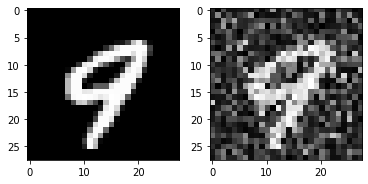

25  :  0.49413942115131854 25
50  :  0.4944218485077188 25
75  :  0.49440467289195905 25
100  :  0.49440467289195905 25
125  :  0.49440467289195905 25
150  :  0.49440467289195905 25
175  :  0.49440467289195905 25
200  :  0.49454992634280254 25
225  :  0.49454992634280254 25
250  :  0.49454992634280254 25
275  :  0.4946696344208845 25
300  :  0.4946696344208845 25
325  :  0.4946699491493804 25
350  :  0.4946696344208845 25
375  :  0.4948743642376839 25
400  :  0.49493524785991966 25
425  :  0.494994150043059 25
450  :  0.494994150043059 25
475  :  0.494994150043059 25
500  :  0.49500557000843914 25
525  :  0.49505298062587866 25
550  :  0.4951669837948179 25
575  :  0.4951669837948179 25
600  :  0.4951669837948179 25
625  :  0.49518823336909573 25
650  :  0.49522953693607774 25
675  :  0.49523372803455357 25
700  :  0.4952487827410215 25
725  :  0.4952509627756104 25
750  :  0.4952895225805709 25
775  :  0.49529715436681493 25
800  :  0.4953024547707894 25
Time:  48.668548583984375  sec

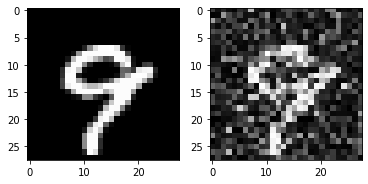

25  :  0.49402915554213384 25
50  :  0.4944970074272747 25
75  :  0.493892767622798 25
100  :  0.4943167382642897 25
125  :  0.494547509956236 25
150  :  0.494364624560788 25
175  :  0.49446739886546676 25
200  :  0.4946109875440129 25
225  :  0.4946098989763793 25
250  :  0.4946098989763793 25
275  :  0.4946098989763793 25
300  :  0.4946098989763793 25
325  :  0.4946098989763793 25
350  :  0.4946098989763793 25
375  :  0.4946098989763793 25
400  :  0.4946098989763793 25
425  :  0.49468855231354136 25
450  :  0.4947291871955602 25
475  :  0.4947714307636718 25
500  :  0.4947714307636718 25
525  :  0.4947714307636718 25
550  :  0.4949548517296399 25
575  :  0.49494543568168664 25
600  :  0.4949456452710999 25
625  :  0.4949456452710999 25
650  :  0.4949456452710999 25
675  :  0.4949456452710999 25
700  :  0.49494796235372607 25
725  :  0.4950637031157946 25
750  :  0.4950639546246515 25
775  :  0.49509431949542515 25
800  :  0.49509431949542515 25
Time:  46.07214426994324  seconds
Predi

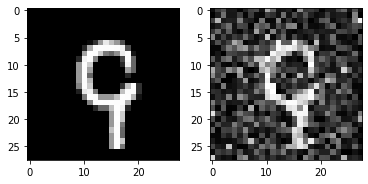

25  :  0.484539954467889 25
50  :  0.4939335287933571 25
75  :  0.49343534844415066 25
100  :  0.4938321167003946 25
125  :  0.4938321167003946 25
150  :  0.4938321167003946 25
175  :  0.49402890211217526 25
200  :  0.49402890211217526 25
225  :  0.49402890211217526 25
250  :  0.49403622152159754 25
275  :  0.49403622152159754 25
300  :  0.4940907743985426 25
325  :  0.49409042154063054 25
350  :  0.4941933192714373 25
375  :  0.4941933192714373 25
400  :  0.49419542328465976 25
425  :  0.49428860434317545 25
450  :  0.49435344589203617 25
475  :  0.49440573770565505 25
500  :  0.49447783161093717 25
525  :  0.494538138178496 25
550  :  0.4945568078109142 25
575  :  0.49461113136066576 25
600  :  0.49468257230833357 25
625  :  0.494736487579416 25
650  :  0.4947364880427898 25
675  :  0.4947859434512588 25
700  :  0.4947859733320592 25
725  :  0.4947859733320592 25
750  :  0.49479570265707123 25
775  :  0.49479570265707123 25
800  :  0.49479570265707123 25
Time:  47.533178091049194  se

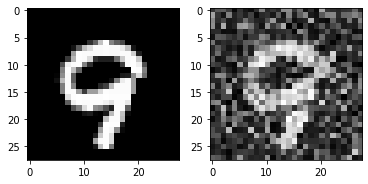

25  :  0.49390000792806593 25
50  :  0.49390000792806593 25
75  :  0.4948916323647233 25
100  :  0.4948916323647233 25
125  :  0.4948916323647233 25
150  :  0.4948916323647233 25
175  :  0.4948916323647233 25
200  :  0.4948916323647233 25
225  :  0.4948916323647233 25
250  :  0.4948916323647233 25
275  :  0.4948916323647233 25
300  :  0.4948916323647233 25
325  :  0.4948916323647233 25
350  :  0.4948916323647233 25
375  :  0.4948916323647233 25
400  :  0.4948916323647233 25
425  :  0.49501208667341007 25
450  :  0.4950365326716804 25
475  :  0.4950365326716804 25
500  :  0.4950365326716804 25
525  :  0.4950365326716804 25
550  :  0.4950365326716804 25
575  :  0.4950365326716804 25
600  :  0.4950365326716804 25
625  :  0.4950365326716804 25
650  :  0.4950365326716804 25
675  :  0.4950365326716804 25
700  :  0.4950365326716804 25
725  :  0.495078118178191 25
750  :  0.49507388642234923 25
775  :  0.49507388642234923 25
800  :  0.49513061221061083 25
Time:  53.90514016151428  seconds
Pred

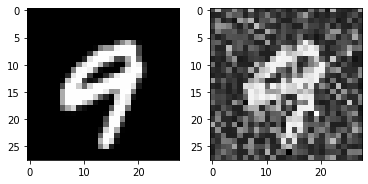

25  :  0.4949999272155308 25
50  :  0.49515372839448213 25
75  :  0.49516532105520833 25
100  :  0.49516532105520833 25
125  :  0.49516532105520833 25
150  :  0.495306182470658 25
175  :  0.49494151240942985 25
200  :  0.49494151240942985 25
225  :  0.49494151240942985 25
250  :  0.4950887067730727 25
275  :  0.4952415213272774 25
300  :  0.49524640323842833 25
325  :  0.4954952674274182 25
350  :  0.4954873033114214 25
375  :  0.4954946625164823 25
400  :  0.4954873033114214 25
425  :  0.4954873033114214 25
450  :  0.4954873033114214 25
475  :  0.49550081395716933 25
500  :  0.49550164255458706 25
525  :  0.4955455616514927 25
550  :  0.49557912509553975 25
575  :  0.49557882243399676 25
600  :  0.49557882243399676 25
625  :  0.49557882243399676 25
650  :  0.49557882243399676 25
675  :  0.49557882243399676 25
700  :  0.4955788614594839 25
725  :  0.49557882243399676 25
750  :  0.49558352404361483 25
775  :  0.4955838527888387 25
800  :  0.4955938382958516 25
Time:  52.27500581741333  

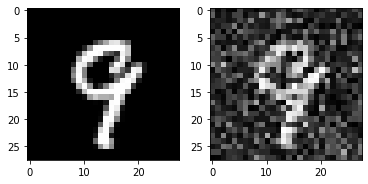

25  :  0.4947277692978905 25
50  :  0.4947277692978905 25
75  :  0.49434827571181805 25
100  :  0.49434827571181805 25
125  :  0.4944031247223083 25
150  :  0.49472428563090187 25
175  :  0.4948608501493725 25
200  :  0.4948608501493725 25
225  :  0.4948608501493725 25
250  :  0.4948608501493725 25
275  :  0.4948608501493725 25
300  :  0.4948608501493725 25
325  :  0.4948608501493725 25
350  :  0.49516215201624575 25
375  :  0.49521919176762735 25
400  :  0.49521919176762735 25
425  :  0.49521919176762735 25
450  :  0.49521919176762735 25
475  :  0.49521919176762735 25
500  :  0.49521919176762735 25
525  :  0.4952451346842466 25
550  :  0.49525026066779 25
575  :  0.4953655744566826 25
600  :  0.49536729941388297 25
625  :  0.49536729941388297 25
650  :  0.49536729941388297 25
675  :  0.49536729941388297 25
700  :  0.4954200939419167 25
725  :  0.4954335968436319 25
750  :  0.49545198218452763 25
775  :  0.49549594006343173 25
800  :  0.4955283317656401 25
Time:  47.07444167137146  sec

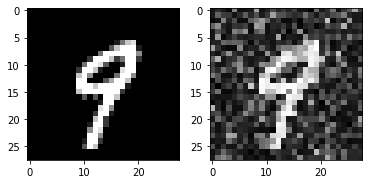

25  :  0.4948697445723687 25
50  :  0.4948697445723687 25
75  :  0.4950409571386132 25
100  :  0.4950797156200462 25
125  :  0.4951843036666466 25
150  :  0.4954381067546008 25
175  :  0.4954381067546008 25
200  :  0.4954381067546008 25
225  :  0.4954381067546008 25
250  :  0.4954381067546008 25
275  :  0.4955213453705279 25
300  :  0.49546370733887046 25
325  :  0.4955888575442749 25
350  :  0.4956182994559927 25
375  :  0.4959601084167273 25
400  :  0.4959601084167273 25
425  :  0.4959601084167273 25
450  :  0.4959601084167273 25
475  :  0.4959601084167273 25
500  :  0.4959601084167273 25
525  :  0.4959601084167273 25
550  :  0.4960079423961419 25
575  :  0.49600452387516286 25
600  :  0.49600452387516286 25
625  :  0.49600452387516286 25
650  :  0.49600452387516286 25
675  :  0.49601666080453677 25
700  :  0.4960333115570206 25
725  :  0.4960506869270743 25
750  :  0.4960506869270743 25
775  :  0.4960702811898406 25
800  :  0.4960702811898406 25
Time:  45.742223501205444  seconds
Pr

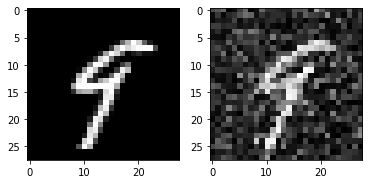

25  :  0.4793510674372244 25
50  :  0.4941979713308391 25
75  :  0.49367139410529565 25
100  :  0.4935231432153627 25
125  :  0.49395980411138596 25
150  :  0.49390135105489597 25
175  :  0.49390135105489597 25
200  :  0.4939808990992705 25
225  :  0.4939933123188977 25
250  :  0.4940630599022226 25
275  :  0.49444572769953943 25
300  :  0.49444572769953943 25
325  :  0.49444572769953943 25
350  :  0.49444572769953943 25
375  :  0.49444572769953943 25
400  :  0.49444572769953943 25
425  :  0.494517599830377 25
450  :  0.49455508845141505 25
475  :  0.49455508845141505 25
500  :  0.49455508845141505 25
525  :  0.49455508845141505 25
550  :  0.49456045784411923 25
575  :  0.49456045784411923 25
600  :  0.49456045784411923 25
625  :  0.4946314743055518 25
650  :  0.4946327251810627 25
675  :  0.4946362388574555 25
700  :  0.49469652690484833 25
725  :  0.49469676772423615 25
750  :  0.49470278999882705 25
775  :  0.4947065720815871 25
800  :  0.4947229841403545 25
825  :  0.49472752748378

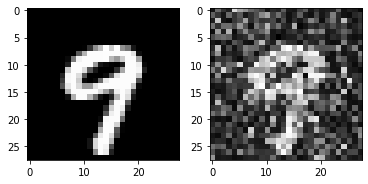

25  :  0.49339200056731713 25
50  :  0.4938991227962749 25
75  :  0.4941735511100401 25
100  :  0.4941735511100401 25
125  :  0.4941735511100401 25
150  :  0.49433836507484863 25
175  :  0.49433836507484863 25
200  :  0.49433836507484863 25
225  :  0.49433836507484863 25
250  :  0.49433836507484863 25
275  :  0.49433836507484863 25
300  :  0.49433836507484863 25
325  :  0.49433836507484863 25
350  :  0.49433836507484863 25
375  :  0.49433836507484863 25
400  :  0.49458096319930334 25
425  :  0.4945287336842378 25
450  :  0.4945287336842378 25
475  :  0.4945287336842378 25
500  :  0.4945287336842378 25
525  :  0.49460336485981604 25
550  :  0.4946920208481 25
575  :  0.4947313414564874 25
600  :  0.4947313414564874 25
625  :  0.49478275525181475 25
650  :  0.4947991567584208 25
675  :  0.4948860648182073 25
700  :  0.4949319877088501 25
725  :  0.4949337718959141 25
750  :  0.49494490621120424 25
775  :  0.49496349772071757 25
800  :  0.49498722057013694 25
Time:  49.613850116729736  se

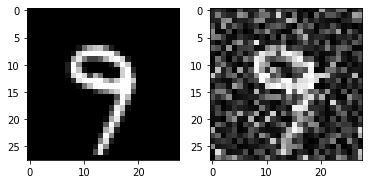

25  :  0.49506440563569715 25
50  :  0.49506440563569715 25
75  :  0.4951743139719991 25
100  :  0.49514376636049207 25
125  :  0.49514376636049207 25
150  :  0.495240544042771 25
175  :  0.4952194960867693 25
200  :  0.4953543314809433 25
225  :  0.49535193604026523 25
250  :  0.4954777715336842 25
275  :  0.4954777715336842 25
300  :  0.4954957237178839 25
325  :  0.4956950521150677 25
350  :  0.4957906910645081 25
375  :  0.4958118352256537 25
400  :  0.4958118352256537 25
425  :  0.49583850220108416 25
450  :  0.4959202051723731 25
475  :  0.4959202051723731 25
500  :  0.4959202051723731 25
525  :  0.4959202051723731 25
550  :  0.4959202051723731 25
575  :  0.49593722442930316 25
600  :  0.4959576057563737 25
625  :  0.4959549253750568 25
650  :  0.4959549253750568 25
675  :  0.4959747340044829 25
700  :  0.4960143121698532 25
725  :  0.49604962513576734 25
750  :  0.49604962513576734 25
775  :  0.49605101946622193 25
800  :  0.4960921944985959 25
Time:  57.50778293609619  seconds


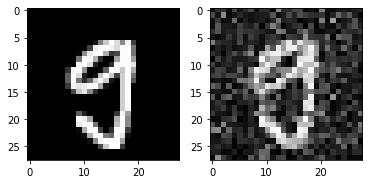

25  :  0.4945124924100534 25
50  :  0.4945124924100534 25
75  :  0.4945124924100534 25
100  :  0.4945124924100534 25
125  :  0.4945124924100534 25
150  :  0.4945124924100534 25
175  :  0.4945124924100534 25
200  :  0.4946803112025938 25
225  :  0.4945955478111792 25
250  :  0.49481698082910114 25
275  :  0.4947473967527113 25
300  :  0.4947473967527113 25
325  :  0.4947473967527113 25
350  :  0.4947578361561282 25
375  :  0.4947578361561282 25
400  :  0.494860506930937 25
425  :  0.4948809503777515 25
450  :  0.49495670561024163 25
475  :  0.4950173256500957 25
500  :  0.49503894406160676 25
525  :  0.49503882525482545 25
550  :  0.49503882525482545 25
575  :  0.49507073171386623 25
600  :  0.4951061680245682 25
625  :  0.49511725771369136 25
650  :  0.49511725771369136 25
675  :  0.49512533043835727 25
700  :  0.49512533043835727 25
725  :  0.49512533043835727 25
750  :  0.49514797750239875 25
775  :  0.49514797750239875 25
800  :  0.4951548490147001 25
Time:  50.341914653778076  seco

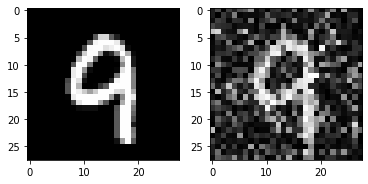

25  :  0.49505485872260696 25
50  :  0.49505485872260696 25
75  :  0.49505485872260696 25
100  :  0.49505485872260696 25
125  :  0.49505485872260696 25
150  :  0.49505485872260696 25
175  :  0.49505485872260696 25
200  :  0.49505485872260696 25
225  :  0.49505485872260696 25
250  :  0.49505485872260696 25
275  :  0.495065265205361 25
300  :  0.4951119028956307 25
325  :  0.4951119028956307 25
350  :  0.4952729699895966 25
375  :  0.4952729699895966 25
400  :  0.4952729699895966 25
425  :  0.4952729699895966 25
450  :  0.4952729699895966 25
475  :  0.49529563169441526 25
500  :  0.49529563169441526 25
525  :  0.49529991456857886 25
550  :  0.49529991456857886 25
575  :  0.49529991456857886 25
600  :  0.4953110319038639 25
625  :  0.4953145329934051 25
650  :  0.4953581021597726 25
675  :  0.4953706448321206 25
700  :  0.4953740872219057 25
725  :  0.4953864876155233 25
750  :  0.49538842123843335 25
775  :  0.4954217819107086 25
800  :  0.4954332505859438 25
Time:  47.19285559654236  se

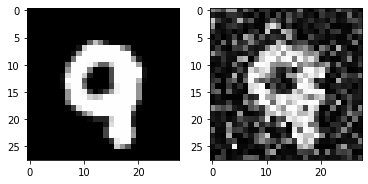

In [9]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28,28,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_cnn_mnist_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [11]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

69.98206543922424
39.74417567253113
45.82044904951065
5.165164155246894


In [12]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1075
800
823.2142857142857
50.412836476761086


In [0]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))